In [1]:
#!/usr/bin/env python3
from argparse import ArgumentParser
import numpy as np
import torch
from data import get_dataset, DATASET_CONFIGS
from train import train
from model import MLP
import utils



import matplotlib.pyplot as plt





In [13]:
task_number = 5
hidden_size=600
hidden_layer_num=2
hidden_dropout_prob=0.5
input_dropout_prob=0.2
lamda=40

epochs_per_task = 30
batch_size = 128
test_size= 4096
fisher_estimation_sample_size= 4096
lr=1.e-3
weight_decay = 0
eval_log_interval = 250
loss_log_interval= 250
cuda=False

# decide whether to use cuda or not.
cuda = torch.cuda.is_available()

# generate permutations for the tasks.
np.random.seed(0)
permutations = [
    np.random.permutation(DATASET_CONFIGS['mnist']['size']**2) for
    _ in range(task_number)
]

# prepare mnist datasets.
train_datasets = [
    get_dataset('mnist', permutation=p) for p in permutations
]
test_datasets = [
    get_dataset('mnist', train=False, permutation=p) for p in permutations
]

    

In [3]:
# prepare the model.
mlp_no_dropout = MLP(
    DATASET_CONFIGS['mnist']['size']**2,
    DATASET_CONFIGS['mnist']['classes'],
    hidden_size,
    hidden_layer_num,
    0,
    0,
    lamda,
)

# initialize the parameters.
utils.xavier_initialize(mlp_no_dropout)

# prepare the cuda if needed.
if cuda:
    mlp_no_dropout.cuda()



In [4]:
def loss_plot(x):
    for t, v in x.items():
        plt.plot(list(range((t-1) * epochs_per_task, t * epochs_per_task)), v)

def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(list(range((t-1) * epochs_per_task, task_number * epochs_per_task)), v)
    plt.ylim(0.7, 1)

In [61]:
def avg_precision_plot(precisions, labels = []): #precisions needs to be in the form of the return value of train
    for num, precision in enumerate(precisions):    
        avg_precisions = []
        total_epochs = task_number*epochs_per_task
        for epoch in range (total_epochs):
            avg_precision = 0
            tasks_considered = epoch // epochs_per_task +1 #gives 1 for first task, 2 for second,...
            for i in range(1,tasks_considered+1): #
                avg_precision += precision[i][epoch - (i-1)*epochs_per_task]
            avg_precision/=tasks_considered
            avg_precisions.append(avg_precision)
        plt.ylim(0.88, 0.94)
        if (len(labels) == len(precisions)):
            plt.plot(range(total_epochs), avg_precisions, label = labels[num])
        else:
            plt.plot(range(total_epochs), avg_precisions)
    plt.legend()
    

In [5]:
# run the standard experiment.
consolidate = False
standard_prec_no_dropout, standard_total_loss_no_dropout, standard_ce_loss_no_dropout, standard_ewc_loss_no_dropout = train(
    mlp_no_dropout, train_datasets, test_datasets,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)

=> task: 1/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.2917 | loss => ce: 2.273 / ewc: 0.0 / total: 2.273: : 469it [00:30, 15.60it/s]
=> task: 1/5 | epoch: 2/30 | progress: [256/60000] (0%) | prec: 0.2578 | loss => ce: 2.274 / ewc: 0.0 / total: 2.274: : 2it [00:00, 14.62it/s]

Test Accuracy {1: [0.264404296875]}
total loss {1: [2.2727010250091553]} cross entropy {1: [2.2727010250091553]} ewc {1: [0.0]}


=> task: 1/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.5 | loss => ce: 2.231 / ewc: 0.0 / total: 2.231: : 469it [00:29, 16.05it/s]   
=> task: 1/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.4297 | loss => ce: 2.238 / ewc: 0.0 / total: 2.238: : 2it [00:00, 14.15it/s]

Test Accuracy {1: [0.264404296875, 0.55078125]}
total loss {1: [2.2727010250091553, 2.230879545211792]} cross entropy {1: [2.2727010250091553, 2.230879545211792]} ewc {1: [0.0, 0.0]}


=> task: 1/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.5521 | loss => ce: 2.153 / ewc: 0.0 / total: 2.153: : 469it [00:28, 16.51it/s]
=> task: 1/5 | epoch: 4/30 | progress: [384/60000] (1%) | prec: 0.5859 | loss => ce: 2.148 / ewc: 0.0 / total: 2.148: : 2it [00:00, 14.55it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534]} ewc {1: [0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.6667 | loss => ce: 2.01 / ewc: 0.0 / total: 2.01: : 469it [00:28, 16.63it/s]  
=> task: 1/5 | epoch: 5/30 | progress: [256/60000] (0%) | prec: 0.6484 | loss => ce: 2.029 / ewc: 0.0 / total: 2.029: : 2it [00:00, 11.84it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664]} ewc {1: [0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.75 | loss => ce: 1.732 / ewc: 0.0 / total: 1.732: : 469it [00:28, 16.46it/s]  
=> task: 1/5 | epoch: 6/30 | progress: [256/60000] (0%) | prec: 0.6719 | loss => ce: 1.754 / ewc: 0.0 / total: 1.754: : 2it [00:00, 12.83it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.75 | loss => ce: 1.432 / ewc: 0.0 / total: 1.432: : 469it [00:28, 16.46it/s] 
=> task: 1/5 | epoch: 7/30 | progress: [256/60000] (0%) | prec: 0.6719 | loss => ce: 1.488 / ewc: 0.0 / total: 1.488: : 2it [00:00, 12.58it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.9961 / ewc: 0.0 / total: 0.9961: : 469it [00:28, 16.56it/s]
=> task: 1/5 | epoch: 8/30 | progress: [256/60000] (0%) | prec: 0.7891 | loss => ce: 1.083 / ewc: 0.0 / total: 1.083: : 2it [00:00, 13.15it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.7604 | loss => ce: 0.8261 / ewc: 0.0 / total: 0.8261: : 469it [00:28, 16.60it/s]
=> task: 1/5 | epoch: 9/30 | progress: [256/60000] (0%) | prec: 0.7578 | loss => ce: 0.8728 / ewc: 0.0 / total: 0.8728: : 2it [00:00, 14.43it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.7812 | loss => ce: 0.7544 / ewc: 0.0 / total: 0.7544: : 469it [00:28, 16.65it/s]
=> task: 1/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.7891 | loss => ce: 0.7599 / ewc: 0.0 / total: 0.7599: : 2it [00:00, 13.57it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.7812 | loss => ce: 0.7126 / ewc: 0.0 / total: 0.7126: : 469it [00:30, 15.41it/s]
=> task: 1/5 | epoch: 11/30 | progress: [128/60000] (0%) | prec: 0.8906 | loss => ce: 0.544 / ewc: 0.0 / total: 0.544: : 0it [00:00, ?it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.8229 | loss => ce: 0.5687 / ewc: 0.0 / total: 0.5687: : 469it [00:29, 15.64it/s]
=> task: 1/5 | epoch: 12/30 | progress: [384/60000] (1%) | prec: 0.8438 | loss => ce: 0.5847 / ewc: 0.0 / total: 0.5847: : 2it [00:00, 15.28it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.8229 | loss => ce: 0.5551 / ewc: 0.0 / total: 0.5551: : 469it [00:28, 16.28it/s]
=> task: 1/5 | epoch: 13/30 | progress: [384/60000] (1%) | prec: 0.9141 | loss => ce: 0.3867 / ewc: 0.0 / total: 0.3867: : 2it [00:00, 14.75it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.4331 / ewc: 0.0 / total: 0.4331: : 469it [00:28, 16.68it/s]
=> task: 1/5 | epoch: 14/30 | progress: [384/60000] (1%) | prec: 0.8281 | loss => ce: 0.4787 / ewc: 0.0 / total: 0.4787: : 2it [00:00, 14.62it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.5729 / ewc: 0.0 / total: 0.5729: : 469it [00:28, 16.59it/s]
=> task: 1/5 | epoch: 15/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.4174 / ewc: 0.0 / total: 0.4174: : 2it [00:00, 14.05it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4414 / ewc: 0.0 / total: 0.4414: : 469it [00:28, 16.51it/s]
=> task: 1/5 | epoch: 16/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.3707 / ewc: 0.0 / total: 0.3707: : 2it [00:00, 13.76it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.4165 / ewc: 0.0 / total: 0.4165: : 469it [00:28, 16.65it/s] 
=> task: 1/5 | epoch: 17/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.4424 / ewc: 0.0 / total: 0.4424: : 2it [00:00, 14.39it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

=> task: 1/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.423 / ewc: 0.0 / total: 0.423: : 469it [00:28, 16.69it/s]  
=> task: 1/5 | epoch: 18/30 | progress: [384/60000] (1%) | prec: 0.8359 | loss => ce: 0.4807 / ewc: 0.0 / total: 0.4807: : 2it [00:00, 14.70it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076]} ewc {1:

=> task: 1/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.4062 / ewc: 0.0 / total: 0.4062: : 469it [00:28, 16.64it/s]
=> task: 1/5 | epoch: 19/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2678 / ewc: 0.0 / total: 0.2678: : 2it [00:00, 14.81it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283

=> task: 1/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3314 / ewc: 0.0 / total: 0.3314: : 469it [00:28, 16.58it/s]
=> task: 1/5 | epoch: 20/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.3112 / ewc: 0.0 / total: 0.3112: : 2it [00:00, 14.35it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772

=> task: 1/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2211 / ewc: 0.0 / total: 0.2211: : 469it [00:28, 16.68it/s]
=> task: 1/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.3324 / ewc: 0.0 / total: 0.3324: : 2it [00:00, 15.16it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.433

=> task: 1/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2875 / ewc: 0.0 / total: 0.2875: : 469it [00:28, 16.59it/s]
=> task: 1/5 | epoch: 22/30 | progress: [384/60000] (1%) | prec: 0.9453 | loss => ce: 0.3161 / ewc: 0.0 / total: 0.3161: : 2it [00:00, 14.87it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466, 0.2875199019908905]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.568668663

=> task: 1/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3431 / ewc: 0.0 / total: 0.3431: : 469it [00:28, 16.45it/s]
=> task: 1/5 | epoch: 23/30 | progress: [384/60000] (1%) | prec: 0.875 | loss => ce: 0.3783 / ewc: 0.0 / total: 0.3783: : 2it [00:00, 15.06it/s] 

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466, 0.2875199019908905, 0.34305238723754883]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.754380881786

=> task: 1/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3767 / ewc: 0.0 / total: 0.3767: : 469it [00:28, 16.63it/s]
=> task: 1/5 | epoch: 24/30 | progress: [384/60000] (1%) | prec: 0.9219 | loss => ce: 0.2559 / ewc: 0.0 / total: 0.2559: : 2it [00:00, 14.67it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466, 0.2875199019908905, 0.34305238723754883, 0.3766528367996216]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598

=> task: 1/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.3561 / ewc: 0.0 / total: 0.3561: : 469it [00:28, 16.74it/s]
=> task: 1/5 | epoch: 25/30 | progress: [384/60000] (1%) | prec: 0.8672 | loss => ce: 0.4355 / ewc: 0.0 / total: 0.4355: : 2it [00:00, 14.96it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466, 0.2875199019908905, 0.34305238723754883, 0.3766528367996216, 0.3560524880886078]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.

=> task: 1/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1892 / ewc: 0.0 / total: 0.1892: : 469it [00:29, 16.06it/s]
=> task: 1/5 | epoch: 26/30 | progress: [384/60000] (1%) | prec: 0.8828 | loss => ce: 0.3303 / ewc: 0.0 / total: 0.3303: : 2it [00:00, 14.85it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466, 0.2875199019908905, 0.34305238723754883, 0.3766528367996216, 0.3560524880886078, 0.18916548788547516]} cross entropy {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.00958347

=> task: 1/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2828 / ewc: 0.0 / total: 0.2828: : 469it [00:30, 15.38it/s]
=> task: 1/5 | epoch: 27/30 | progress: [384/60000] (1%) | prec: 0.9141 | loss => ce: 0.2888 / ewc: 0.0 / total: 0.2888: : 2it [00:00, 15.00it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466, 0.2875199019908905, 0.34305238723754883, 0.3766528367996216, 0.3560524880886078, 0.18916548788547516, 0.2828251123428345]} cross entropy {1: [2.2727010250091553, 2.2308795452

=> task: 1/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.3274 / ewc: 0.0 / total: 0.3274: : 469it [00:29, 15.94it/s]
=> task: 1/5 | epoch: 28/30 | progress: [384/60000] (1%) | prec: 0.9141 | loss => ce: 0.4303 / ewc: 0.0 / total: 0.4303: : 2it [00:00, 15.25it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466, 0.2875199019908905, 0.34305238723754883, 0.3766528367996216, 0.3560524880886078, 0.18916548788547516, 0.2828251123428345, 0.3273757994174957]} cross entropy {1

=> task: 1/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2796 / ewc: 0.0 / total: 0.2796: : 469it [00:30, 15.55it/s]
=> task: 1/5 | epoch: 29/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.19 / ewc: 0.0 / total: 0.19: : 2it [00:00, 15.16it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466, 0.2875199019908905, 0.34305238723754883, 0.3766528367996216, 0.3560524880886078, 0.18916548788547516, 0.2828251123428345, 0.3273757994174957, 0

=> task: 1/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.4684 / ewc: 0.0 / total: 0.4684: : 469it [00:29, 16.11it/s]
=> task: 1/5 | epoch: 30/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2857 / ewc: 0.0 / total: 0.2857: : 2it [00:00, 14.34it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466, 0.2875199019908905, 0.34305238723754883, 0.3766528367996216, 0.3560524880886078, 0.18916548788547516, 0.2828251123428345, 0.327

=> task: 1/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2482 / ewc: 0.0 / total: 0.2482: : 469it [00:28, 16.61it/s]
=> task: 2/5 | epoch: 1/30 | progress: [384/60000] (1%) | prec: 0.1172 | loss => ce: 2.44 / ewc: 0.0 / total: 2.44: : 2it [00:00, 14.50it/s]  

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466, 0.2875199019908905, 0.34305238723754883, 0.3766528367996216, 0.3560524880886078, 0.18916548788547516, 0.28282511

=> task: 2/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.8125 | loss => ce: 0.8797 / ewc: 0.0 / total: 0.8797: : 469it [00:28, 16.54it/s]
=> task: 2/5 | epoch: 2/30 | progress: [384/60000] (1%) | prec: 0.7656 | loss => ce: 0.8653 / ewc: 0.0 / total: 0.8653: : 2it [00:00, 14.73it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875], 2: [0.7900390625]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466, 0.2875199019908905, 0.34305238723754883, 0.3766528367996216, 0.35605248808860

=> task: 2/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.6154 / ewc: 0.0 / total: 0.6154: : 469it [00:28, 16.51it/s]
=> task: 2/5 | epoch: 3/30 | progress: [384/60000] (1%) | prec: 0.8594 | loss => ce: 0.6145 / ewc: 0.0 / total: 0.6145: : 2it [00:00, 14.46it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625], 2: [0.7900390625, 0.8486328125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466, 0.2875199019908905, 0.34305238723754883, 0.37665

=> task: 2/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3389 / ewc: 0.0 / total: 0.3389: : 469it [00:28, 16.60it/s]
=> task: 2/5 | epoch: 4/30 | progress: [384/60000] (1%) | prec: 0.9141 | loss => ce: 0.3832 / ewc: 0.0 / total: 0.3832: : 2it [00:00, 14.71it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375], 2: [0.7900390625, 0.8486328125, 0.874267578125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.22112780809402466, 0.28751990199089

=> task: 2/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.3843 / ewc: 0.0 / total: 0.3843: : 469it [00:28, 16.59it/s]
=> task: 2/5 | epoch: 5/30 | progress: [384/60000] (1%) | prec: 0.8594 | loss => ce: 0.4873 / ewc: 0.0 / total: 0.4873: : 2it [00:00, 14.76it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3313967287540436, 0.221127808

=> task: 2/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2813 / ewc: 0.0 / total: 0.2813: : 469it [00:28, 16.56it/s]
=> task: 2/5 | epoch: 6/30 | progress: [384/60000] (1%) | prec: 0.8828 | loss => ce: 0.3719 / ewc: 0.0 / total: 0.3719: : 2it [00:00, 14.43it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.42296016216278076, 0.40617191791534424, 0.3

=> task: 2/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.4069 / ewc: 0.0 / total: 0.4069: : 469it [00:28, 16.66it/s]
=> task: 2/5 | epoch: 7/30 | progress: [384/60000] (1%) | prec: 0.8906 | loss => ce: 0.4322 / ewc: 0.0 / total: 0.4322: : 2it [00:00, 14.73it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4165307283401489, 0.4229601621627

=> task: 2/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2291 / ewc: 0.0 / total: 0.2291: : 469it [00:28, 16.66it/s]
=> task: 2/5 | epoch: 8/30 | progress: [384/60000] (1%) | prec: 0.9062 | loss => ce: 0.3247 / ewc: 0.0 / total: 0.3247: : 2it [00:00, 14.61it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980941772, 0.44136786460876465, 0.4

=> task: 2/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.4247 / ewc: 0.0 / total: 0.4247: : 469it [00:28, 16.68it/s]
=> task: 2/5 | epoch: 9/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.3613 / ewc: 0.0 / total: 0.3613: : 2it [00:00, 14.66it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.43305572867393494, 0.5729058980

=> task: 2/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.2919 / ewc: 0.0 / total: 0.2919: : 469it [00:28, 16.63it/s]
=> task: 2/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.4628 / ewc: 0.0 / total: 0.4628: : 2it [00:00, 14.58it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686635017395, 0.555088460445404, 0.

=> task: 2/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.3812 / ewc: 0.0 / total: 0.3812: : 469it [00:28, 16.70it/s]
=> task: 2/5 | epoch: 11/30 | progress: [384/60000] (1%) | prec: 0.875 | loss => ce: 0.4118 / ewc: 0.0 / total: 0.4118: : 2it [00:00, 14.47it/s] 

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.7543808817863464, 0.7126345634460449, 0.5686686

=> task: 2/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4096 / ewc: 0.0 / total: 0.4096: : 469it [00:28, 16.63it/s]
=> task: 2/5 | epoch: 12/30 | progress: [384/60000] (1%) | prec: 0.9141 | loss => ce: 0.3223 / ewc: 0.0 / total: 0.3223: : 2it [00:00, 14.83it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.917236328125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.8260995745658875, 0.754380881786346

=> task: 2/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2253 / ewc: 0.0 / total: 0.2253: : 469it [00:28, 16.69it/s]
=> task: 2/5 | epoch: 13/30 | progress: [384/60000] (1%) | prec: 0.8438 | loss => ce: 0.4396 / ewc: 0.0 / total: 0.4396: : 2it [00:00, 14.25it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.917236328125, 0.920654296875]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782, 0.9960845112800598, 0.826

=> task: 2/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4115 / ewc: 0.0 / total: 0.4115: : 469it [00:28, 16.51it/s]
=> task: 2/5 | epoch: 14/30 | progress: [384/60000] (1%) | prec: 0.9453 | loss => ce: 0.1965 / ewc: 0.0 / total: 0.1965: : 2it [00:00, 14.94it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.917236328125, 0.920654296875, 0.9140625]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077560425, 1.4320789575576782

=> task: 2/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2473 / ewc: 0.0 / total: 0.2473: : 469it [00:28, 16.64it/s]
=> task: 2/5 | epoch: 15/30 | progress: [384/60000] (1%) | prec: 0.8984 | loss => ce: 0.2424 / ewc: 0.0 / total: 0.2424: : 2it [00:00, 14.18it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.917236328125, 0.920654296875, 0.9140625, 0.923583984375]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2.0095834732055664, 1.7318772077

=> task: 2/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2851 / ewc: 0.0 / total: 0.2851: : 469it [00:28, 16.65it/s]
=> task: 2/5 | epoch: 16/30 | progress: [384/60000] (1%) | prec: 0.9219 | loss => ce: 0.2512 / ewc: 0.0 / total: 0.2512: : 2it [00:00, 14.64it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.917236328125, 0.920654296875, 0.9140625, 0.923583984375, 0.92236328125]}
total loss {1: [2.2727010250091553, 2.230879545211792, 2.153332471847534, 2

=> task: 2/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2148 / ewc: 0.0 / total: 0.2148: : 469it [00:30, 15.48it/s]
=> task: 2/5 | epoch: 17/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.3703 / ewc: 0.0 / total: 0.3703: : 2it [00:00, 13.76it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.917236328125, 0.920654296875, 0.9140625, 0.923583984375, 0.92236328125, 0.9228515625]}
total loss {1: [2.2727010250091553, 2.2308795

=> task: 2/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.3535 / ewc: 0.0 / total: 0.3535: : 469it [00:31, 15.01it/s]
=> task: 2/5 | epoch: 18/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.3488 / ewc: 0.0 / total: 0.3488: : 2it [00:00, 14.32it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.917236328125, 0.920654296875, 0.9140625, 0.923583984375, 0.92236328125, 0.9228515625, 0.91796875]}
total loss {1: [2

=> task: 2/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2616 / ewc: 0.0 / total: 0.2616: : 469it [00:29, 15.71it/s]
=> task: 2/5 | epoch: 19/30 | progress: [384/60000] (1%) | prec: 0.9297 | loss => ce: 0.2219 / ewc: 0.0 / total: 0.2219: : 2it [00:00, 14.59it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.917236328125, 0.920654296875, 0.9140625, 0.923583984375, 0.92236328125, 0.9228515625, 0.91796875, 0.

=> task: 2/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2766 / ewc: 0.0 / total: 0.2766: : 469it [00:29, 16.01it/s]
=> task: 2/5 | epoch: 20/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.2661 / ewc: 0.0 / total: 0.2661: : 2it [00:00, 14.56it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.917236328125, 0.920654296875, 0.9140625, 0.923583984375, 0.92236328125, 0.9228515625, 

=> task: 2/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2038 / ewc: 0.0 / total: 0.2038: : 469it [00:28, 16.51it/s]
=> task: 2/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.349 / ewc: 0.0 / total: 0.349: : 2it [00:00, 14.23it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.917236328125, 0.920654296875, 0.9140625, 0.923583984375, 0.92236328125,

=> task: 2/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.3511 / ewc: 0.0 / total: 0.3511: : 469it [00:28, 16.49it/s] 
=> task: 2/5 | epoch: 22/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.2918 / ewc: 0.0 / total: 0.2918: : 2it [00:00, 12.52it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.917236328125, 0.920654296875, 0.9140625, 0.923583984375,

=> task: 2/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3747 / ewc: 0.0 / total: 0.3747: : 469it [00:28, 16.19it/s]
=> task: 2/5 | epoch: 23/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.2839 / ewc: 0.0 / total: 0.2839: : 2it [00:00, 14.42it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.917236328125, 0.920654296875, 0.9140625,

=> task: 2/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.202 / ewc: 0.0 / total: 0.202: : 469it [00:28, 16.56it/s]  
=> task: 2/5 | epoch: 24/30 | progress: [384/60000] (1%) | prec: 0.9531 | loss => ce: 0.2005 / ewc: 0.0 / total: 0.2005: : 2it [00:00, 14.93it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.917236328125, 0.9206542968

=> task: 2/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1928 / ewc: 0.0 / total: 0.1928: : 469it [00:28, 16.60it/s] 
=> task: 2/5 | epoch: 25/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.2484 / ewc: 0.0 / total: 0.2484: : 2it [00:00, 14.19it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.907470703125, 0.9172363281

=> task: 2/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1371 / ewc: 0.0 / total: 0.1371: : 469it [00:28, 16.54it/s] 
=> task: 2/5 | epoch: 26/30 | progress: [256/60000] (0%) | prec: 0.9531 | loss => ce: 0.1901 / ewc: 0.0 / total: 0.1901: : 2it [00:00, 14.35it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125, 0.90747070312

=> task: 2/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2308 / ewc: 0.0 / total: 0.2308: : 469it [00:28, 16.65it/s] 
=> task: 2/5 | epoch: 27/30 | progress: [384/60000] (1%) | prec: 0.9531 | loss => ce: 0.1578 / ewc: 0.0 / total: 0.1578: : 2it [00:00, 14.89it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0.913330078125

=> task: 2/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2109 / ewc: 0.0 / total: 0.2109: : 469it [00:28, 16.70it/s] 
=> task: 2/5 | epoch: 28/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2692 / ewc: 0.0 / total: 0.2692: : 2it [00:00, 14.43it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0.906005859375, 0

=> task: 2/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1668 / ewc: 0.0 / total: 0.1668: : 469it [00:28, 16.66it/s]
=> task: 2/5 | epoch: 29/30 | progress: [384/60000] (1%) | prec: 0.9531 | loss => ce: 0.1836 / ewc: 0.0 / total: 0.1836: : 2it [00:00, 14.67it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.907958984375, 0

=> task: 2/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2427 / ewc: 0.0 / total: 0.2427: : 469it [00:28, 16.68it/s] 
=> task: 2/5 | epoch: 30/30 | progress: [384/60000] (1%) | prec: 0.9531 | loss => ce: 0.1843 / ewc: 0.0 / total: 0.1843: : 2it [00:00, 14.80it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0.8896484375, 0.

=> task: 2/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2546 / ewc: 0.0 / total: 0.2546: : 469it [00:28, 16.66it/s] 
=> task: 3/5 | epoch: 1/30 | progress: [256/60000] (0%) | prec: 0.1953 | loss => ce: 2.707 / ewc: 0.0 / total: 2.707: : 2it [00:00, 13.95it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 0.88818359375, 0

=> task: 3/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.5131 / ewc: 0.0 / total: 0.5131: : 469it [00:28, 16.63it/s]
=> task: 3/5 | epoch: 2/30 | progress: [256/60000] (0%) | prec: 0.8516 | loss => ce: 0.5458 / ewc: 0.0 / total: 0.5458: : 2it [00:00, 13.04it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375], 2: [0.7900390625, 0.8486328125, 0.874267578125, 0.88427734375, 

=> task: 3/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.351 / ewc: 0.0 / total: 0.351: : 469it [00:28, 16.57it/s]  
=> task: 3/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.4558 / ewc: 0.0 / total: 0.4558: : 2it [00:00, 13.90it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375], 2: [0.7900390625, 0.8486328125, 0.874267578125,

=> task: 3/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.4424 / ewc: 0.0 / total: 0.4424: : 469it [00:28, 16.67it/s]
=> task: 3/5 | epoch: 4/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.4884 / ewc: 0.0 / total: 0.4884: : 2it [00:00, 14.41it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125], 2: [0.7900390625, 0.8486328125,

=> task: 3/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.3408 / ewc: 0.0 / total: 0.3408: : 469it [00:28, 16.63it/s]
=> task: 3/5 | epoch: 5/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.3399 / ewc: 0.0 / total: 0.3399: : 2it [00:00, 14.64it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125], 2: [0.790039062

=> task: 3/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.345 / ewc: 0.0 / total: 0.345: : 469it [00:28, 16.66it/s]  
=> task: 3/5 | epoch: 6/30 | progress: [384/60000] (1%) | prec: 0.875 | loss => ce: 0.3077 / ewc: 0.0 / total: 0.3077: : 2it [00:00, 14.49it/s] 

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875], 2: 

=> task: 3/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2668 / ewc: 0.0 / total: 0.2668: : 469it [00:28, 16.67it/s]
=> task: 3/5 | epoch: 7/30 | progress: [384/60000] (1%) | prec: 0.9219 | loss => ce: 0.2842 / ewc: 0.0 / total: 0.2842: : 2it [00:00, 14.56it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2037 / ewc: 0.0 / total: 0.2037: : 469it [00:28, 16.69it/s]
=> task: 3/5 | epoch: 8/30 | progress: [384/60000] (1%) | prec: 0.9453 | loss => ce: 0.2229 / ewc: 0.0 / total: 0.2229: : 2it [00:00, 14.60it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2698 / ewc: 0.0 / total: 0.2698: : 469it [00:28, 16.65it/s]
=> task: 3/5 | epoch: 9/30 | progress: [256/60000] (0%) | prec: 0.9688 | loss => ce: 0.2014 / ewc: 0.0 / total: 0.2014: : 2it [00:00, 14.10it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3224 / ewc: 0.0 / total: 0.3224: : 469it [00:28, 16.62it/s]
=> task: 3/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.3349 / ewc: 0.0 / total: 0.3349: : 2it [00:00, 14.59it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2723 / ewc: 0.0 / total: 0.2723: : 469it [00:28, 16.68it/s]
=> task: 3/5 | epoch: 11/30 | progress: [384/60000] (1%) | prec: 0.9375 | loss => ce: 0.2299 / ewc: 0.0 / total: 0.2299: : 2it [00:00, 14.47it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.1916 / ewc: 0.0 / total: 0.1916: : 469it [00:28, 16.72it/s]
=> task: 3/5 | epoch: 12/30 | progress: [384/60000] (1%) | prec: 0.9297 | loss => ce: 0.2098 / ewc: 0.0 / total: 0.2098: : 2it [00:00, 14.22it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3153 / ewc: 0.0 / total: 0.3153: : 469it [00:28, 16.69it/s] 
=> task: 3/5 | epoch: 13/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.207 / ewc: 0.0 / total: 0.207: : 2it [00:00, 13.62it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1754 / ewc: 0.0 / total: 0.1754: : 469it [00:28, 16.63it/s] 
=> task: 3/5 | epoch: 14/30 | progress: [256/60000] (0%) | prec: 0.9531 | loss => ce: 0.2352 / ewc: 0.0 / total: 0.2352: : 2it [00:00, 14.65it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1317 / ewc: 0.0 / total: 0.1317: : 469it [00:28, 16.72it/s]
=> task: 3/5 | epoch: 15/30 | progress: [256/60000] (0%) | prec: 0.9453 | loss => ce: 0.2017 / ewc: 0.0 / total: 0.2017: : 2it [00:00, 14.92it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2045 / ewc: 0.0 / total: 0.2045: : 469it [00:28, 16.72it/s] 
=> task: 3/5 | epoch: 16/30 | progress: [384/60000] (1%) | prec: 0.9062 | loss => ce: 0.2926 / ewc: 0.0 / total: 0.2926: : 2it [00:00, 14.28it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1627 / ewc: 0.0 / total: 0.1627: : 469it [00:28, 16.65it/s] 
=> task: 3/5 | epoch: 17/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2648 / ewc: 0.0 / total: 0.2648: : 2it [00:00, 13.84it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.2918 / ewc: 0.0 / total: 0.2918: : 469it [00:29, 16.04it/s]
=> task: 3/5 | epoch: 18/30 | progress: [128/60000] (0%) | prec: 0.9766 | loss => ce: 0.08892 / ewc: 0.0 / total: 0.08892: : 1it [00:00,  9.41it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.252 / ewc: 0.0 / total: 0.252: : 469it [00:29, 15.82it/s]   
=> task: 3/5 | epoch: 19/30 | progress: [256/60000] (0%) | prec: 0.9453 | loss => ce: 0.1676 / ewc: 0.0 / total: 0.1676: : 2it [00:00, 13.89it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4403 / ewc: 0.0 / total: 0.4403: : 469it [00:28, 16.62it/s] 
=> task: 3/5 | epoch: 20/30 | progress: [384/60000] (1%) | prec: 0.9375 | loss => ce: 0.2533 / ewc: 0.0 / total: 0.2533: : 2it [00:00, 14.61it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1221 / ewc: 0.0 / total: 0.1221: : 469it [00:28, 16.63it/s] 
=> task: 3/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.9453 | loss => ce: 0.2219 / ewc: 0.0 / total: 0.2219: : 2it [00:00, 13.78it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3881 / ewc: 0.0 / total: 0.3881: : 469it [00:28, 16.57it/s] 
=> task: 3/5 | epoch: 22/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.1825 / ewc: 0.0 / total: 0.1825: : 2it [00:00, 14.04it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2085 / ewc: 0.0 / total: 0.2085: : 469it [00:28, 16.61it/s] 
=> task: 3/5 | epoch: 23/30 | progress: [256/60000] (0%) | prec: 0.9766 | loss => ce: 0.09078 / ewc: 0.0 / total: 0.09078: : 2it [00:00, 14.32it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3002 / ewc: 0.0 / total: 0.3002: : 469it [00:28, 16.71it/s] 
=> task: 3/5 | epoch: 24/30 | progress: [384/60000] (1%) | prec: 0.9453 | loss => ce: 0.163 / ewc: 0.0 / total: 0.163: : 2it [00:00, 15.11it/s]  

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.2242 / ewc: 0.0 / total: 0.2242: : 469it [00:28, 16.70it/s] 
=> task: 3/5 | epoch: 25/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2315 / ewc: 0.0 / total: 0.2315: : 2it [00:00, 14.47it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1289 / ewc: 0.0 / total: 0.1289: : 469it [00:28, 16.67it/s] 
=> task: 3/5 | epoch: 26/30 | progress: [384/60000] (1%) | prec: 0.9766 | loss => ce: 0.1201 / ewc: 0.0 / total: 0.1201: : 2it [00:00, 14.78it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2386 / ewc: 0.0 / total: 0.2386: : 469it [00:28, 16.66it/s] 
=> task: 3/5 | epoch: 27/30 | progress: [256/60000] (0%) | prec: 0.9922 | loss => ce: 0.08305 / ewc: 0.0 / total: 0.08305: : 2it [00:00, 14.58it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.2168 / ewc: 0.0 / total: 0.2168: : 469it [00:29, 15.74it/s]  
=> task: 3/5 | epoch: 28/30 | progress: [384/60000] (1%) | prec: 0.9609 | loss => ce: 0.1489 / ewc: 0.0 / total: 0.1489: : 2it [00:00, 14.65it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.1536 / ewc: 0.0 / total: 0.1536: : 469it [00:28, 16.66it/s] 
=> task: 3/5 | epoch: 29/30 | progress: [384/60000] (1%) | prec: 0.9609 | loss => ce: 0.2174 / ewc: 0.0 / total: 0.2174: : 2it [00:00, 14.73it/s]  

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1556 / ewc: 0.0 / total: 0.1556: : 469it [00:28, 16.72it/s] 
=> task: 3/5 | epoch: 30/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.1852 / ewc: 0.0 / total: 0.1852: : 2it [00:00, 14.38it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 3/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.09627 / ewc: 0.0 / total: 0.09627: : 469it [00:28, 16.71it/s]
=> task: 4/5 | epoch: 1/30 | progress: [384/60000] (1%) | prec: 0.1172 | loss => ce: 2.698 / ewc: 0.0 / total: 2.698: : 2it [00:00, 14.68it/s] 

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.8021 | loss => ce: 0.6212 / ewc: 0.0 / total: 0.6212: : 469it [00:28, 16.68it/s]
=> task: 4/5 | epoch: 2/30 | progress: [384/60000] (1%) | prec: 0.8516 | loss => ce: 0.438 / ewc: 0.0 / total: 0.438: : 2it [00:00, 14.55it/s]  

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.4857 / ewc: 0.0 / total: 0.4857: : 469it [00:28, 16.68it/s]
=> task: 4/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.3319 / ewc: 0.0 / total: 0.3319: : 2it [00:00, 14.35it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2699 / ewc: 0.0 / total: 0.2699: : 469it [00:28, 16.68it/s]
=> task: 4/5 | epoch: 4/30 | progress: [384/60000] (1%) | prec: 0.8906 | loss => ce: 0.3186 / ewc: 0.0 / total: 0.3186: : 2it [00:00, 14.58it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2938 / ewc: 0.0 / total: 0.2938: : 469it [00:29, 15.93it/s]
=> task: 4/5 | epoch: 5/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.2261 / ewc: 0.0 / total: 0.2261: : 2it [00:00, 13.77it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1616 / ewc: 0.0 / total: 0.1616: : 469it [00:28, 16.65it/s]
=> task: 4/5 | epoch: 6/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.2449 / ewc: 0.0 / total: 0.2449: : 2it [00:00, 14.65it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.1594 / ewc: 0.0 / total: 0.1594: : 469it [00:28, 16.63it/s]
=> task: 4/5 | epoch: 7/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.2399 / ewc: 0.0 / total: 0.2399: : 2it [00:00, 14.17it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.1805 / ewc: 0.0 / total: 0.1805: : 469it [00:28, 16.70it/s]
=> task: 4/5 | epoch: 8/30 | progress: [384/60000] (1%) | prec: 0.9609 | loss => ce: 0.198 / ewc: 0.0 / total: 0.198: : 2it [00:00, 14.54it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2102 / ewc: 0.0 / total: 0.2102: : 469it [00:28, 16.63it/s]
=> task: 4/5 | epoch: 9/30 | progress: [384/60000] (1%) | prec: 0.8984 | loss => ce: 0.2705 / ewc: 0.0 / total: 0.2705: : 2it [00:00, 15.05it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2512 / ewc: 0.0 / total: 0.2512: : 469it [00:28, 16.65it/s]
=> task: 4/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.9531 | loss => ce: 0.1373 / ewc: 0.0 / total: 0.1373: : 2it [00:00, 14.15it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1858 / ewc: 0.0 / total: 0.1858: : 469it [00:28, 16.65it/s]
=> task: 4/5 | epoch: 11/30 | progress: [384/60000] (1%) | prec: 0.9375 | loss => ce: 0.2115 / ewc: 0.0 / total: 0.2115: : 2it [00:00, 14.81it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2204 / ewc: 0.0 / total: 0.2204: : 469it [00:28, 16.69it/s] 
=> task: 4/5 | epoch: 12/30 | progress: [256/60000] (0%) | prec: 0.9609 | loss => ce: 0.2168 / ewc: 0.0 / total: 0.2168: : 2it [00:00, 14.13it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2263 / ewc: 0.0 / total: 0.2263: : 469it [00:28, 16.69it/s] 
=> task: 4/5 | epoch: 13/30 | progress: [384/60000] (1%) | prec: 0.8984 | loss => ce: 0.2875 / ewc: 0.0 / total: 0.2875: : 2it [00:00, 14.67it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2164 / ewc: 0.0 / total: 0.2164: : 469it [00:28, 16.70it/s] 
=> task: 4/5 | epoch: 14/30 | progress: [384/60000] (1%) | prec: 0.9219 | loss => ce: 0.2889 / ewc: 0.0 / total: 0.2889: : 2it [00:00, 14.47it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1682 / ewc: 0.0 / total: 0.1682: : 469it [00:28, 16.66it/s] 
=> task: 4/5 | epoch: 15/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.3286 / ewc: 0.0 / total: 0.3286: : 2it [00:00, 14.28it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2737 / ewc: 0.0 / total: 0.2737: : 469it [00:28, 16.65it/s] 
=> task: 4/5 | epoch: 16/30 | progress: [384/60000] (1%) | prec: 0.9375 | loss => ce: 0.2369 / ewc: 0.0 / total: 0.2369: : 2it [00:00, 14.73it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1483 / ewc: 0.0 / total: 0.1483: : 469it [00:28, 16.67it/s] 
=> task: 4/5 | epoch: 17/30 | progress: [384/60000] (1%) | prec: 0.9609 | loss => ce: 0.1621 / ewc: 0.0 / total: 0.1621: : 2it [00:00, 14.34it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.1952 / ewc: 0.0 / total: 0.1952: : 469it [00:28, 16.63it/s] 
=> task: 4/5 | epoch: 18/30 | progress: [384/60000] (1%) | prec: 0.9844 | loss => ce: 0.1163 / ewc: 0.0 / total: 0.1163: : 2it [00:00, 14.56it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1517 / ewc: 0.0 / total: 0.1517: : 469it [00:28, 16.26it/s] 
=> task: 4/5 | epoch: 19/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.2161 / ewc: 0.0 / total: 0.2161: : 2it [00:00, 13.24it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.1582 / ewc: 0.0 / total: 0.1582: : 469it [00:30, 15.54it/s]  
=> task: 4/5 | epoch: 20/30 | progress: [256/60000] (0%) | prec: 0.9688 | loss => ce: 0.1251 / ewc: 0.0 / total: 0.1251: : 2it [00:00, 13.95it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.2495 / ewc: 0.0 / total: 0.2495: : 469it [00:28, 16.61it/s] 
=> task: 4/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.2142 / ewc: 0.0 / total: 0.2142: : 2it [00:00, 14.15it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.1868 / ewc: 0.0 / total: 0.1868: : 469it [00:29, 15.93it/s] 
=> task: 4/5 | epoch: 22/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.231 / ewc: 0.0 / total: 0.231: : 2it [00:00, 13.94it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1264 / ewc: 0.0 / total: 0.1264: : 469it [00:28, 16.49it/s] 
=> task: 4/5 | epoch: 23/30 | progress: [256/60000] (0%) | prec: 0.9609 | loss => ce: 0.1519 / ewc: 0.0 / total: 0.1519: : 2it [00:00, 14.41it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1556 / ewc: 0.0 / total: 0.1556: : 469it [00:28, 16.55it/s] 
=> task: 4/5 | epoch: 24/30 | progress: [256/60000] (0%) | prec: 0.9531 | loss => ce: 0.1123 / ewc: 0.0 / total: 0.1123: : 2it [00:00, 13.99it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1038 / ewc: 0.0 / total: 0.1038: : 469it [00:28, 16.66it/s] 
=> task: 4/5 | epoch: 25/30 | progress: [256/60000] (0%) | prec: 0.9688 | loss => ce: 0.1493 / ewc: 0.0 / total: 0.1493: : 2it [00:00, 14.09it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1288 / ewc: 0.0 / total: 0.1288: : 469it [00:28, 16.65it/s] 
=> task: 4/5 | epoch: 26/30 | progress: [256/60000] (0%) | prec: 0.9688 | loss => ce: 0.1516 / ewc: 0.0 / total: 0.1516: : 2it [00:00, 13.88it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1632 / ewc: 0.0 / total: 0.1632: : 469it [00:28, 16.71it/s]  
=> task: 4/5 | epoch: 27/30 | progress: [384/60000] (1%) | prec: 0.9688 | loss => ce: 0.0897 / ewc: 0.0 / total: 0.0897: : 2it [00:00, 14.60it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.09359 / ewc: 0.0 / total: 0.09359: : 469it [00:28, 16.68it/s]
=> task: 4/5 | epoch: 28/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.1885 / ewc: 0.0 / total: 0.1885: : 2it [00:00, 14.43it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.226 / ewc: 0.0 / total: 0.226: : 469it [00:28, 16.67it/s]    
=> task: 4/5 | epoch: 29/30 | progress: [384/60000] (1%) | prec: 0.9453 | loss => ce: 0.1221 / ewc: 0.0 / total: 0.1221: : 2it [00:00, 14.65it/s]  

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08392 / ewc: 0.0 / total: 0.08392: : 469it [00:28, 16.62it/s]
=> task: 4/5 | epoch: 30/30 | progress: [384/60000] (1%) | prec: 0.9609 | loss => ce: 0.1524 / ewc: 0.0 / total: 0.1524: : 2it [00:00, 14.67it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 4/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2639 / ewc: 0.0 / total: 0.2639: : 469it [00:28, 16.67it/s]  
=> task: 5/5 | epoch: 1/30 | progress: [384/60000] (1%) | prec: 0.07812 | loss => ce: 3.9 / ewc: 0.0 / total: 3.9: : 2it [00:00, 14.67it/s]    

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.348 / ewc: 0.0 / total: 0.348: : 469it [00:28, 16.60it/s] 
=> task: 5/5 | epoch: 2/30 | progress: [256/60000] (0%) | prec: 0.8047 | loss => ce: 0.5695 / ewc: 0.0 / total: 0.5695: : 2it [00:00, 13.92it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.4267 / ewc: 0.0 / total: 0.4267: : 469it [00:28, 16.64it/s] 
=> task: 5/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.3815 / ewc: 0.0 / total: 0.3815: : 2it [00:00, 13.90it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.4789 / ewc: 0.0 / total: 0.4789: : 469it [00:28, 16.74it/s]
=> task: 5/5 | epoch: 4/30 | progress: [384/60000] (1%) | prec: 0.8984 | loss => ce: 0.2857 / ewc: 0.0 / total: 0.2857: : 2it [00:00, 14.10it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2483 / ewc: 0.0 / total: 0.2483: : 469it [00:28, 16.61it/s]
=> task: 5/5 | epoch: 5/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.2853 / ewc: 0.0 / total: 0.2853: : 2it [00:00, 14.22it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.3321 / ewc: 0.0 / total: 0.3321: : 469it [00:28, 16.26it/s]
=> task: 5/5 | epoch: 6/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2995 / ewc: 0.0 / total: 0.2995: : 2it [00:00, 14.81it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.359 / ewc: 0.0 / total: 0.359: : 469it [00:28, 16.61it/s]  
=> task: 5/5 | epoch: 7/30 | progress: [384/60000] (1%) | prec: 0.9688 | loss => ce: 0.1308 / ewc: 0.0 / total: 0.1308: : 2it [00:00, 14.39it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2082 / ewc: 0.0 / total: 0.2082: : 469it [00:28, 16.68it/s] 
=> task: 5/5 | epoch: 8/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2112 / ewc: 0.0 / total: 0.2112: : 2it [00:00, 13.46it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2963 / ewc: 0.0 / total: 0.2963: : 469it [00:28, 16.69it/s] 
=> task: 5/5 | epoch: 9/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.2025 / ewc: 0.0 / total: 0.2025: : 2it [00:00, 13.92it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2917 / ewc: 0.0 / total: 0.2917: : 469it [00:29, 16.12it/s] 
=> task: 5/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.2203 / ewc: 0.0 / total: 0.2203: : 2it [00:00, 14.39it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1456 / ewc: 0.0 / total: 0.1456: : 469it [00:28, 16.55it/s] 
=> task: 5/5 | epoch: 11/30 | progress: [256/60000] (0%) | prec: 0.9688 | loss => ce: 0.1103 / ewc: 0.0 / total: 0.1103: : 2it [00:00, 14.67it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.2573 / ewc: 0.0 / total: 0.2573: : 469it [00:28, 16.64it/s] 
=> task: 5/5 | epoch: 12/30 | progress: [256/60000] (0%) | prec: 0.9766 | loss => ce: 0.1078 / ewc: 0.0 / total: 0.1078: : 2it [00:00, 14.17it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1395 / ewc: 0.0 / total: 0.1395: : 469it [00:28, 16.53it/s] 
=> task: 5/5 | epoch: 13/30 | progress: [256/60000] (0%) | prec: 0.9453 | loss => ce: 0.2686 / ewc: 0.0 / total: 0.2686: : 2it [00:00, 14.52it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1709 / ewc: 0.0 / total: 0.1709: : 469it [00:28, 16.73it/s] 
=> task: 5/5 | epoch: 14/30 | progress: [384/60000] (1%) | prec: 0.9844 | loss => ce: 0.1038 / ewc: 0.0 / total: 0.1038: : 2it [00:00, 14.77it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1893 / ewc: 0.0 / total: 0.1893: : 469it [00:28, 16.73it/s] 
=> task: 5/5 | epoch: 15/30 | progress: [256/60000] (0%) | prec: 0.9688 | loss => ce: 0.1657 / ewc: 0.0 / total: 0.1657: : 2it [00:00, 13.86it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.2402 / ewc: 0.0 / total: 0.2402: : 469it [00:28, 16.74it/s] 
=> task: 5/5 | epoch: 16/30 | progress: [384/60000] (1%) | prec: 0.9844 | loss => ce: 0.07815 / ewc: 0.0 / total: 0.07815: : 2it [00:00, 14.56it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1372 / ewc: 0.0 / total: 0.1372: : 469it [00:28, 16.67it/s] 
=> task: 5/5 | epoch: 17/30 | progress: [256/60000] (0%) | prec: 0.9531 | loss => ce: 0.1658 / ewc: 0.0 / total: 0.1658: : 2it [00:00, 14.57it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.08656 / ewc: 0.0 / total: 0.08656: : 469it [00:28, 16.69it/s]
=> task: 5/5 | epoch: 18/30 | progress: [384/60000] (1%) | prec: 0.9531 | loss => ce: 0.2238 / ewc: 0.0 / total: 0.2238: : 2it [00:00, 14.38it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.0945 / ewc: 0.0 / total: 0.0945: : 469it [00:28, 16.23it/s] 
=> task: 5/5 | epoch: 19/30 | progress: [256/60000] (0%) | prec: 0.9609 | loss => ce: 0.1648 / ewc: 0.0 / total: 0.1648: : 2it [00:00, 13.72it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2217 / ewc: 0.0 / total: 0.2217: : 469it [00:28, 16.65it/s] 
=> task: 5/5 | epoch: 20/30 | progress: [384/60000] (1%) | prec: 0.9766 | loss => ce: 0.1118 / ewc: 0.0 / total: 0.1118: : 2it [00:00, 14.57it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.1813 / ewc: 0.0 / total: 0.1813: : 469it [00:28, 16.72it/s] 
=> task: 5/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.9766 | loss => ce: 0.09612 / ewc: 0.0 / total: 0.09612: : 2it [00:00, 13.96it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.07794 / ewc: 0.0 / total: 0.07794: : 469it [00:28, 16.71it/s]
=> task: 5/5 | epoch: 22/30 | progress: [256/60000] (0%) | prec: 0.9766 | loss => ce: 0.1332 / ewc: 0.0 / total: 0.1332: : 2it [00:00, 14.12it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.1781 / ewc: 0.0 / total: 0.1781: : 469it [00:28, 16.74it/s] 
=> task: 5/5 | epoch: 23/30 | progress: [384/60000] (1%) | prec: 0.9375 | loss => ce: 0.2581 / ewc: 0.0 / total: 0.2581: : 2it [00:00, 14.48it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.13 / ewc: 0.0 / total: 0.13: : 469it [00:28, 16.70it/s]      
=> task: 5/5 | epoch: 24/30 | progress: [384/60000] (1%) | prec: 0.9531 | loss => ce: 0.1543 / ewc: 0.0 / total: 0.1543: : 2it [00:00, 14.51it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1283 / ewc: 0.0 / total: 0.1283: : 469it [00:28, 16.66it/s] 
=> task: 5/5 | epoch: 25/30 | progress: [256/60000] (0%) | prec: 0.9688 | loss => ce: 0.2399 / ewc: 0.0 / total: 0.2399: : 2it [00:00, 14.18it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.0654 / ewc: 0.0 / total: 0.0654: : 469it [00:28, 16.70it/s] 
=> task: 5/5 | epoch: 26/30 | progress: [384/60000] (1%) | prec: 0.9375 | loss => ce: 0.1672 / ewc: 0.0 / total: 0.1672: : 2it [00:00, 14.63it/s]  

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05357 / ewc: 0.0 / total: 0.05357: : 469it [00:28, 16.69it/s]
=> task: 5/5 | epoch: 27/30 | progress: [256/60000] (0%) | prec: 0.9531 | loss => ce: 0.1388 / ewc: 0.0 / total: 0.1388: : 2it [00:00, 14.13it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.08619 / ewc: 0.0 / total: 0.08619: : 469it [00:27, 16.76it/s]
=> task: 5/5 | epoch: 28/30 | progress: [256/60000] (0%) | prec: 0.9766 | loss => ce: 0.09024 / ewc: 0.0 / total: 0.09024: : 2it [00:00, 14.04it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2406 / ewc: 0.0 / total: 0.2406: : 469it [00:28, 16.68it/s] 
=> task: 5/5 | epoch: 29/30 | progress: [384/60000] (1%) | prec: 0.9766 | loss => ce: 0.1079 / ewc: 0.0 / total: 0.1079: : 2it [00:00, 14.50it/s]  

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05329 / ewc: 0.0 / total: 0.05329: : 469it [00:28, 16.71it/s]
=> task: 5/5 | epoch: 30/30 | progress: [256/60000] (0%) | prec: 0.9922 | loss => ce: 0.04839 / ewc: 0.0 / total: 0.04839: : 2it [00:00, 14.27it/s]

Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

=> task: 5/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.03454 / ewc: 0.0 / total: 0.03454: : 469it [00:28, 16.72it/s]   


Test Accuracy {1: [0.264404296875, 0.55078125, 0.6298828125, 0.65087890625, 0.69384765625, 0.7333984375, 0.792236328125, 0.82275390625, 0.836181640625, 0.85693359375, 0.86376953125, 0.869873046875, 0.883544921875, 0.8837890625, 0.88525390625, 0.895751953125, 0.891845703125, 0.892822265625, 0.90771484375, 0.900390625, 0.908203125, 0.904541015625, 0.907470703125, 0.911865234375, 0.8984375, 0.909912109375, 0.91064453125, 0.910888671875, 0.919677734375, 0.91650390625, 0.887451171875, 0.88525390625, 0.888427734375, 0.8828125, 0.888671875, 0.888427734375, 0.888427734375, 0.878662109375, 0.88720703125, 0.887939453125, 0.893798828125, 0.887451171875, 0.887939453125, 0.890625, 0.893310546875, 0.889892578125, 0.883544921875, 0.884521484375, 0.8896484375, 0.89013671875, 0.89306640625, 0.885498046875, 0.8876953125, 0.894775390625, 0.89013671875, 0.88818359375, 0.892578125, 0.889892578125, 0.89111328125, 0.89404296875, 0.878662109375, 0.882568359375, 0.878173828125, 0.882080078125, 0.88671875, 0.88

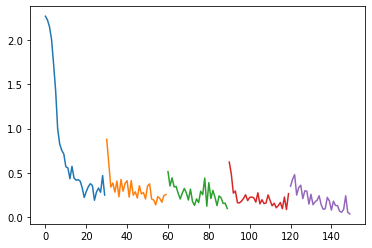

In [6]:
loss_plot(standard_total_loss_no_dropout)

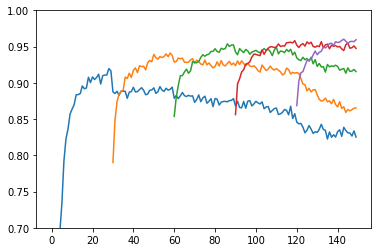

In [7]:
accuracy_plot(standard_prec_no_dropout)

No handles with labels found to put in legend.


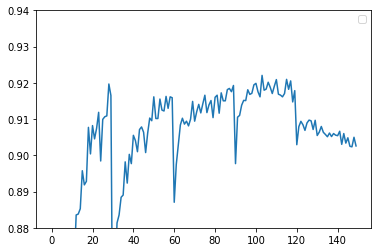

In [62]:
avg_precision_plot([standard_prec_no_dropout])

In [8]:
# prepare the model.
mlp = MLP(
    DATASET_CONFIGS['mnist']['size']**2,
    DATASET_CONFIGS['mnist']['classes'],
    hidden_size,
    hidden_layer_num,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

# initialize the parameters.
utils.xavier_initialize(mlp)

# prepare the cuda if needed.
if cuda:
    mlp.cuda()

In [14]:
# run the standard experiment.
consolidate = False
standard_prec, standard_total_loss, standard_ce_loss, standard_ewc_loss = train(
    mlp, train_datasets, test_datasets,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)

=> task: 1/5 | epoch: 1/30 | progress: [6656/60000] (11%) | prec: 0.8438 | loss => ce: 0.8327 / ewc: 0.0 / total: 0.8327: : 52it [00:04, 12.22it/s]


KeyboardInterrupt: 

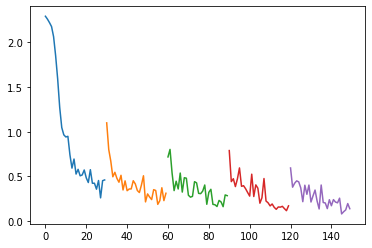

In [10]:
loss_plot(standard_total_loss)

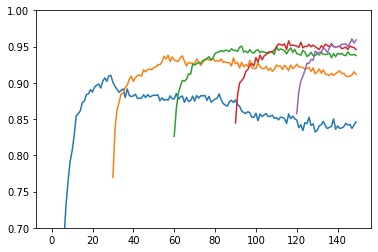

In [11]:
accuracy_plot(standard_prec)

No handles with labels found to put in legend.


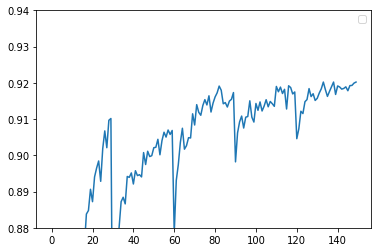

In [63]:
avg_precision_plot([standard_prec])

In [15]:
mlp_consolidation = MLP(
    DATASET_CONFIGS['mnist']['size']**2,
    DATASET_CONFIGS['mnist']['classes'],
    hidden_size,
    hidden_layer_num,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.xavier_initialize(mlp_consolidation)

# run the standard experiment.
consolidate = True
ewc_prec, ewc_total_loss, ewc_ce_loss, ewc_ewc_loss =train(
    mlp_consolidation, train_datasets, test_datasets,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)

=> task: 1/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.1875 | loss => ce: 2.283 / ewc: 0.0 / total: 2.283: : 469it [00:36, 12.95it/s]
=> task: 1/5 | epoch: 2/30 | progress: [256/60000] (0%) | prec: 0.1641 | loss => ce: 2.274 / ewc: 0.0 / total: 2.274: : 2it [00:00, 11.99it/s]

Test Accuracy {1: [0.288330078125]}
total loss {1: [2.283116340637207]} cross entropy {1: [2.283116340637207]} ewc {1: [0.0]}


=> task: 1/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.2292 | loss => ce: 2.259 / ewc: 0.0 / total: 2.259: : 469it [00:33, 13.89it/s]
=> task: 1/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.3047 | loss => ce: 2.252 / ewc: 0.0 / total: 2.252: : 2it [00:00, 14.01it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125]}
total loss {1: [2.283116340637207, 2.259303331375122]} cross entropy {1: [2.283116340637207, 2.259303331375122]} ewc {1: [0.0, 0.0]}


=> task: 1/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.3021 | loss => ce: 2.224 / ewc: 0.0 / total: 2.224: : 469it [00:29, 16.07it/s]
=> task: 1/5 | epoch: 4/30 | progress: [384/60000] (1%) | prec: 0.3438 | loss => ce: 2.215 / ewc: 0.0 / total: 2.215: : 2it [00:00, 14.78it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346]} ewc {1: [0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.4583 | loss => ce: 2.168 / ewc: 0.0 / total: 2.168: : 469it [00:28, 16.30it/s]
=> task: 1/5 | epoch: 5/30 | progress: [384/60000] (1%) | prec: 0.3516 | loss => ce: 2.169 / ewc: 0.0 / total: 2.169: : 2it [00:00, 14.69it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453]} ewc {1: [0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.4479 | loss => ce: 2.062 / ewc: 0.0 / total: 2.062: : 469it [00:28, 16.22it/s]
=> task: 1/5 | epoch: 6/30 | progress: [256/60000] (0%) | prec: 0.5469 | loss => ce: 2.003 / ewc: 0.0 / total: 2.003: : 2it [00:00, 14.29it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.5521 | loss => ce: 1.798 / ewc: 0.0 / total: 1.798: : 469it [00:28, 16.31it/s]
=> task: 1/5 | epoch: 7/30 | progress: [384/60000] (1%) | prec: 0.5547 | loss => ce: 1.828 / ewc: 0.0 / total: 1.828: : 2it [00:00, 14.70it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.4896 | loss => ce: 1.593 / ewc: 0.0 / total: 1.593: : 469it [00:28, 16.33it/s]
=> task: 1/5 | epoch: 8/30 | progress: [384/60000] (1%) | prec: 0.5078 | loss => ce: 1.614 / ewc: 0.0 / total: 1.614: : 2it [00:00, 14.86it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.6042 | loss => ce: 1.334 / ewc: 0.0 / total: 1.334: : 469it [00:28, 16.37it/s]
=> task: 1/5 | epoch: 9/30 | progress: [384/60000] (1%) | prec: 0.6094 | loss => ce: 1.361 / ewc: 0.0 / total: 1.361: : 2it [00:00, 14.98it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.6771 | loss => ce: 1.049 / ewc: 0.0 / total: 1.049: : 469it [00:28, 16.39it/s] 
=> task: 1/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.6719 | loss => ce: 1.139 / ewc: 0.0 / total: 1.139: : 2it [00:00, 14.27it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.6875 | loss => ce: 0.9829 / ewc: 0.0 / total: 0.9829: : 469it [00:28, 16.35it/s]
=> task: 1/5 | epoch: 11/30 | progress: [384/60000] (1%) | prec: 0.6953 | loss => ce: 0.9122 / ewc: 0.0 / total: 0.9122: : 2it [00:00, 15.55it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.75 | loss => ce: 0.8191 / ewc: 0.0 / total: 0.8191: : 469it [00:28, 16.50it/s]  
=> task: 1/5 | epoch: 12/30 | progress: [384/60000] (1%) | prec: 0.7266 | loss => ce: 0.8562 / ewc: 0.0 / total: 0.8562: : 2it [00:00, 15.72it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.7917 | loss => ce: 0.7652 / ewc: 0.0 / total: 0.7652: : 469it [00:28, 16.47it/s]
=> task: 1/5 | epoch: 13/30 | progress: [384/60000] (1%) | prec: 0.7266 | loss => ce: 0.8166 / ewc: 0.0 / total: 0.8166: : 2it [00:00, 15.69it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.8021 | loss => ce: 0.6549 / ewc: 0.0 / total: 0.6549: : 469it [00:28, 16.41it/s]
=> task: 1/5 | epoch: 14/30 | progress: [384/60000] (1%) | prec: 0.8203 | loss => ce: 0.6216 / ewc: 0.0 / total: 0.6216: : 2it [00:00, 15.55it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.621 / ewc: 0.0 / total: 0.621: : 469it [00:28, 16.44it/s]  
=> task: 1/5 | epoch: 15/30 | progress: [384/60000] (1%) | prec: 0.8125 | loss => ce: 0.6179 / ewc: 0.0 / total: 0.6179: : 2it [00:00, 15.76it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.7812 | loss => ce: 0.7404 / ewc: 0.0 / total: 0.7404: : 469it [00:28, 16.41it/s]
=> task: 1/5 | epoch: 16/30 | progress: [384/60000] (1%) | prec: 0.8359 | loss => ce: 0.5294 / ewc: 0.0 / total: 0.5294: : 2it [00:00, 15.43it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.8125 | loss => ce: 0.6459 / ewc: 0.0 / total: 0.6459: : 469it [00:28, 16.42it/s]
=> task: 1/5 | epoch: 17/30 | progress: [384/60000] (1%) | prec: 0.8281 | loss => ce: 0.5731 / ewc: 0.0 / total: 0.5731: : 2it [00:00, 15.43it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

=> task: 1/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.8125 | loss => ce: 0.6678 / ewc: 0.0 / total: 0.6678: : 469it [00:28, 16.37it/s]
=> task: 1/5 | epoch: 18/30 | progress: [128/60000] (0%) | prec: 0.8438 | loss => ce: 0.5862 / ewc: 0.0 / total: 0.5862: : 1it [00:00,  9.05it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338]} ewc {1: [0

=> task: 1/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.5095 / ewc: 0.0 / total: 0.5095: : 469it [00:31, 15.02it/s]
=> task: 1/5 | epoch: 19/30 | progress: [384/60000] (1%) | prec: 0.7969 | loss => ce: 0.5294 / ewc: 0.0 / total: 0.5294: : 2it [00:00, 15.06it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806

=> task: 1/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.8125 | loss => ce: 0.6273 / ewc: 0.0 / total: 0.6273: : 469it [00:32, 14.31it/s]
=> task: 1/5 | epoch: 20/30 | progress: [256/60000] (0%) | prec: 0.8047 | loss => ce: 0.6359 / ewc: 0.0 / total: 0.6359: : 2it [00:00, 14.43it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171,

=> task: 1/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.5267 / ewc: 0.0 / total: 0.5267: : 469it [00:30, 15.41it/s]
=> task: 1/5 | epoch: 21/30 | progress: [384/60000] (1%) | prec: 0.7969 | loss => ce: 0.6006 / ewc: 0.0 / total: 0.6006: : 2it [00:00, 15.11it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.65494

=> task: 1/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.5136 / ewc: 0.0 / total: 0.5136: : 469it [00:31, 14.93it/s]
=> task: 1/5 | epoch: 22/30 | progress: [384/60000] (1%) | prec: 0.8359 | loss => ce: 0.5273 / ewc: 0.0 / total: 0.5273: : 2it [00:00, 15.50it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103, 0.5136113166809082]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248

=> task: 1/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.4626 / ewc: 0.0 / total: 0.4626: : 469it [00:29, 15.80it/s]
=> task: 1/5 | epoch: 23/30 | progress: [384/60000] (1%) | prec: 0.8438 | loss => ce: 0.4869 / ewc: 0.0 / total: 0.4869: : 2it [00:00, 15.76it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103, 0.5136113166809082, 0.4625891149044037]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978

=> task: 1/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3482 / ewc: 0.0 / total: 0.3482: : 469it [00:28, 16.46it/s]
=> task: 1/5 | epoch: 24/30 | progress: [384/60000] (1%) | prec: 0.8828 | loss => ce: 0.3944 / ewc: 0.0 / total: 0.3944: : 2it [00:00, 16.14it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103, 0.5136113166809082, 0.4625891149044037, 0.3482324779033661]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292,

=> task: 1/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4168 / ewc: 0.0 / total: 0.4168: : 469it [00:28, 16.43it/s]
=> task: 1/5 | epoch: 25/30 | progress: [384/60000] (1%) | prec: 0.8594 | loss => ce: 0.4501 / ewc: 0.0 / total: 0.4501: : 2it [00:00, 15.62it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103, 0.5136113166809082, 0.4625891149044037, 0.3482324779033661, 0.4167846143245697]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.79

=> task: 1/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.8229 | loss => ce: 0.6292 / ewc: 0.0 / total: 0.6292: : 469it [00:28, 16.31it/s]
=> task: 1/5 | epoch: 26/30 | progress: [384/60000] (1%) | prec: 0.8672 | loss => ce: 0.4649 / ewc: 0.0 / total: 0.4649: : 2it [00:00, 15.15it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103, 0.5136113166809082, 0.4625891149044037, 0.3482324779033661, 0.4167846143245697, 0.6292270421981812]} cross entropy {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.168291091

=> task: 1/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3427 / ewc: 0.0 / total: 0.3427: : 469it [00:28, 16.37it/s]
=> task: 1/5 | epoch: 27/30 | progress: [384/60000] (1%) | prec: 0.8984 | loss => ce: 0.3999 / ewc: 0.0 / total: 0.3999: : 2it [00:00, 15.81it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103, 0.5136113166809082, 0.4625891149044037, 0.3482324779033661, 0.4167846143245697, 0.6292270421981812, 0.34265920519828796]} cross entropy {1: [2.283116340637207, 2.2593033313751

=> task: 1/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.7917 | loss => ce: 0.6728 / ewc: 0.0 / total: 0.6728: : 469it [00:28, 16.49it/s]
=> task: 1/5 | epoch: 28/30 | progress: [384/60000] (1%) | prec: 0.8438 | loss => ce: 0.4939 / ewc: 0.0 / total: 0.4939: : 2it [00:00, 15.91it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103, 0.5136113166809082, 0.4625891149044037, 0.3482324779033661, 0.4167846143245697, 0.6292270421981812, 0.34265920519828796, 0.672792911529541]} cross entropy {1: 

=> task: 1/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.4269 / ewc: 0.0 / total: 0.4269: : 469it [00:28, 16.46it/s]
=> task: 1/5 | epoch: 29/30 | progress: [384/60000] (1%) | prec: 0.8438 | loss => ce: 0.4856 / ewc: 0.0 / total: 0.4856: : 2it [00:00, 15.60it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103, 0.5136113166809082, 0.4625891149044037, 0.3482324779033661, 0.4167846143245697, 0.6292270421981812, 0.34265920519828796, 0.672792911529541, 0.4

=> task: 1/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2545 / ewc: 0.0 / total: 0.2545: : 469it [00:28, 16.53it/s]
=> task: 1/5 | epoch: 30/30 | progress: [384/60000] (1%) | prec: 0.8594 | loss => ce: 0.3733 / ewc: 0.0 / total: 0.3733: : 2it [00:00, 16.26it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103, 0.5136113166809082, 0.4625891149044037, 0.3482324779033661, 0.4167846143245697, 0.6292270421981812, 0.34265920519828796, 0.67279

=> task: 1/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.4891 / ewc: 0.0 / total: 0.4891: : 469it [00:28, 16.48it/s]


Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103, 0.5136113166809082, 0.4625891149044037, 0.3482324779033661, 0.4167846143245697, 0.6292270421981812, 0.342659205198

0it [00:00, ?it/s]

 Done!


=> task: 2/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.7083 | loss => ce: 0.9607 / ewc: 0.007176 / total: 0.9679: : 469it [00:32, 14.27it/s]
=> task: 2/5 | epoch: 2/30 | progress: [256/60000] (0%) | prec: 0.7734 | loss => ce: 0.854 / ewc: 0.007204 / total: 0.8612: : 2it [00:00, 13.10it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375], 2: [0.78662109375]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103, 0.5136113166809082, 0.4625891149044037, 0.3482324779033661, 0.4167846143245697

=> task: 2/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.7812 | loss => ce: 0.7124 / ewc: 0.01315 / total: 0.7255: : 469it [00:31, 14.78it/s]
=> task: 2/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.7969 | loss => ce: 0.7742 / ewc: 0.01317 / total: 0.7874: : 2it [00:00, 14.35it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125], 2: [0.78662109375, 0.841064453125]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103, 0.5136113166809082, 0.4625891149044037, 0.3482324

=> task: 2/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.8125 | loss => ce: 0.7365 / ewc: 0.01699 / total: 0.7535: : 469it [00:31, 14.71it/s]
=> task: 2/5 | epoch: 4/30 | progress: [256/60000] (0%) | prec: 0.8594 | loss => ce: 0.5679 / ewc: 0.017 / total: 0.5849: : 2it [00:00, 14.15it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125], 2: [0.78662109375, 0.841064453125, 0.862548828125]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.5267452597618103, 0.5136113166809082,

=> task: 2/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.4582 / ewc: 0.01974 / total: 0.478: : 469it [00:31, 14.77it/s] 
=> task: 2/5 | epoch: 5/30 | progress: [256/60000] (0%) | prec: 0.8047 | loss => ce: 0.6268 / ewc: 0.01975 / total: 0.6466: : 2it [00:00, 14.14it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0.6272611618041992, 0.526745

=> task: 2/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.4744 / ewc: 0.02197 / total: 0.4964: : 469it [00:31, 14.82it/s]
=> task: 2/5 | epoch: 6/30 | progress: [256/60000] (0%) | prec: 0.8125 | loss => ce: 0.5609 / ewc: 0.02199 / total: 0.5829: : 2it [00:00, 13.87it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.6677687168121338, 0.5095232129096985, 0

=> task: 2/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.5258 / ewc: 0.0239 / total: 0.5497: : 469it [00:31, 14.83it/s] 
=> task: 2/5 | epoch: 7/30 | progress: [256/60000] (0%) | prec: 0.8438 | loss => ce: 0.5335 / ewc: 0.02391 / total: 0.5574: : 2it [00:00, 13.99it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.6459053754806519, 0.667768716

=> task: 2/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.3405 / ewc: 0.02554 / total: 0.3661: : 469it [00:31, 14.83it/s]
=> task: 2/5 | epoch: 8/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.4331 / ewc: 0.02555 / total: 0.4587: : 2it [00:00, 13.84it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010063171, 0.7404305338859558, 0.

=> task: 2/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.5122 / ewc: 0.02702 / total: 0.5393: : 469it [00:31, 14.83it/s]
=> task: 2/5 | epoch: 9/30 | progress: [256/60000] (0%) | prec: 0.8203 | loss => ce: 0.4505 / ewc: 0.02703 / total: 0.4775: : 2it [00:00, 13.89it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 0.6549479365348816, 0.6210348010

=> task: 2/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.5312 / ewc: 0.0284 / total: 0.5596: : 469it [00:31, 14.76it/s]
=> task: 2/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.8594 | loss => ce: 0.485 / ewc: 0.02841 / total: 0.5134: : 2it [00:00, 12.83it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755248069763, 0.7652220726013184, 

=> task: 2/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3733 / ewc: 0.0296 / total: 0.4029: : 469it [00:33, 14.09it/s]
=> task: 2/5 | epoch: 11/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.4264 / ewc: 0.0296 / total: 0.456: : 2it [00:00, 11.08it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.9828948378562927, 0.8190755

=> task: 2/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.3331 / ewc: 0.03077 / total: 0.3639: : 469it [00:36, 13.00it/s] 
=> task: 2/5 | epoch: 12/30 | progress: [128/60000] (0%) | prec: 0.8828 | loss => ce: 0.4347 / ewc: 0.03078 / total: 0.4655: : 1it [00:00,  7.43it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984375]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370840549469, 1.049160361289978, 0.

=> task: 2/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4226 / ewc: 0.03187 / total: 0.4545: : 469it [00:36, 12.68it/s]
=> task: 2/5 | epoch: 13/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.4962 / ewc: 0.03187 / total: 0.5281: : 2it [00:00, 13.42it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984375, 0.907958984375]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691, 1.5931929349899292, 1.33370

=> task: 2/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.5112 / ewc: 0.03283 / total: 0.544: : 469it [00:35, 13.17it/s] 
=> task: 2/5 | epoch: 14/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.3945 / ewc: 0.03284 / total: 0.4273: : 2it [00:00, 12.51it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984375, 0.907958984375, 0.908203125]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.0618298053741455, 1.7983002662658691

=> task: 2/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.5393 / ewc: 0.03369 / total: 0.573: : 469it [00:35, 13.24it/s] 
=> task: 2/5 | epoch: 15/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.3586 / ewc: 0.03369 / total: 0.3923: : 2it [00:00, 13.14it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984375, 0.907958984375, 0.908203125, 0.912841796875]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.2243454456329346, 2.1682910919189453, 2.061829

=> task: 2/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3873 / ewc: 0.03457 / total: 0.4218: : 469it [00:32, 14.43it/s]
=> task: 2/5 | epoch: 16/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.3063 / ewc: 0.03457 / total: 0.3409: : 2it [00:00, 13.55it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984375, 0.907958984375, 0.908203125, 0.912841796875, 0.916259765625]}
total loss {1: [2.283116340637207, 2.259303331375122, 2.224345445632934

=> task: 2/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.376 / ewc: 0.03537 / total: 0.4114: : 469it [00:32, 14.62it/s]
=> task: 2/5 | epoch: 17/30 | progress: [256/60000] (0%) | prec: 0.8359 | loss => ce: 0.507 / ewc: 0.03538 / total: 0.5424: : 2it [00:00, 13.39it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984375, 0.907958984375, 0.908203125, 0.912841796875, 0.916259765625, 0.911865234375]}
total loss {1: [2.283116340637207, 2.25

=> task: 2/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3917 / ewc: 0.03614 / total: 0.4278: : 469it [00:32, 14.46it/s]
=> task: 2/5 | epoch: 18/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.4342 / ewc: 0.03615 / total: 0.4703: : 2it [00:00, 13.60it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984375, 0.907958984375, 0.908203125, 0.912841796875, 0.916259765625, 0.911865234375, 0.91552734375]}
total lo

=> task: 2/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.3836 / ewc: 0.03692 / total: 0.4206: : 469it [00:32, 14.57it/s] 
=> task: 2/5 | epoch: 19/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.437 / ewc: 0.03693 / total: 0.4739: : 2it [00:00, 13.69it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984375, 0.907958984375, 0.908203125, 0.912841796875, 0.916259765625, 0.911865234375, 0.915527

=> task: 2/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.259 / ewc: 0.03762 / total: 0.2967: : 469it [00:32, 14.51it/s] 
=> task: 2/5 | epoch: 20/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.3473 / ewc: 0.03762 / total: 0.3849: : 2it [00:00, 13.62it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984375, 0.907958984375, 0.908203125, 0.912841796875, 0.916259765625, 0.9118652

=> task: 2/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3348 / ewc: 0.03827 / total: 0.3731: : 469it [00:32, 14.62it/s]
=> task: 2/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.4268 / ewc: 0.03828 / total: 0.4651: : 2it [00:00, 13.73it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984375, 0.907958984375, 0.908203125, 0.912841796875, 0.91625976

=> task: 2/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3058 / ewc: 0.0389 / total: 0.3447: : 469it [00:31, 14.71it/s]
=> task: 2/5 | epoch: 22/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.4052 / ewc: 0.0389 / total: 0.4441: : 2it [00:00, 13.83it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984375, 0.907958984375, 0.908203125, 0.912841796

=> task: 2/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.408 / ewc: 0.03952 / total: 0.4475: : 469it [00:31, 14.70it/s] 
=> task: 2/5 | epoch: 23/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.3133 / ewc: 0.03951 / total: 0.3528: : 2it [00:00, 13.91it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984375, 0.907958984375, 0.9082031

=> task: 2/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2176 / ewc: 0.0401 / total: 0.2577: : 469it [00:31, 14.80it/s]
=> task: 2/5 | epoch: 24/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.2743 / ewc: 0.0401 / total: 0.3144: : 2it [00:00, 13.68it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984375, 0.9079589

=> task: 2/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3321 / ewc: 0.04063 / total: 0.3727: : 469it [00:31, 14.67it/s]
=> task: 2/5 | epoch: 25/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.3127 / ewc: 0.04064 / total: 0.3533: : 2it [00:00, 14.01it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169921875, 0.8984

=> task: 2/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3143 / ewc: 0.04122 / total: 0.3556: : 469it [00:31, 14.78it/s]
=> task: 2/5 | epoch: 26/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2553 / ewc: 0.04123 / total: 0.2965: : 2it [00:00, 13.98it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287109375, 0.899169

=> task: 2/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2986 / ewc: 0.04172 / total: 0.3403: : 469it [00:31, 14.78it/s]
=> task: 2/5 | epoch: 27/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.3776 / ewc: 0.04171 / total: 0.4193: : 2it [00:00, 13.62it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.89501953125, 0.894287

=> task: 2/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.4675 / ewc: 0.04225 / total: 0.5098: : 469it [00:31, 14.72it/s]
=> task: 2/5 | epoch: 28/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.4247 / ewc: 0.04225 / total: 0.467: : 2it [00:00, 13.97it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.888916015625, 0.895019

=> task: 2/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.449 / ewc: 0.04276 / total: 0.4917: : 469it [00:31, 14.80it/s]  
=> task: 2/5 | epoch: 29/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.2996 / ewc: 0.04276 / total: 0.3423: : 2it [00:00, 13.92it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.88720703125, 0.8889160

=> task: 2/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.4526 / ewc: 0.04324 / total: 0.4959: : 469it [00:31, 14.84it/s]
=> task: 2/5 | epoch: 30/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.3051 / ewc: 0.04324 / total: 0.3483: : 2it [00:00, 13.99it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.88330078125, 0.887207031

=> task: 2/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.2465 / ewc: 0.04373 / total: 0.2902: : 469it [00:31, 14.83it/s]


Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.873291015625, 0.8833007812

0it [00:00, ?it/s]

 Done!


=> task: 3/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.75 | loss => ce: 0.8071 / ewc: 0.008052 / total: 0.8151: : 469it [00:32, 14.31it/s]  
=> task: 3/5 | epoch: 2/30 | progress: [256/60000] (0%) | prec: 0.7422 | loss => ce: 0.8315 / ewc: 0.008078 / total: 0.8396: : 2it [00:00, 14.15it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375], 2: [0.78662109375, 0.841064453125, 0.862548828125, 0.87329101562

=> task: 3/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.7812 | loss => ce: 0.6747 / ewc: 0.01287 / total: 0.6876: : 469it [00:33, 14.08it/s]
=> task: 3/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.8359 | loss => ce: 0.5561 / ewc: 0.01289 / total: 0.569: : 2it [00:00, 14.21it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125], 2: [0.78662109375, 0.841064453125, 0.86254882812

=> task: 3/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.7812 | loss => ce: 0.7488 / ewc: 0.01593 / total: 0.7647: : 469it [00:32, 14.58it/s]
=> task: 3/5 | epoch: 4/30 | progress: [256/60000] (0%) | prec: 0.7578 | loss => ce: 0.6428 / ewc: 0.01594 / total: 0.6588: : 2it [00:00, 14.26it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625], 2: [0.78662109375, 0.84106445312

=> task: 3/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.4613 / ewc: 0.01826 / total: 0.4796: : 469it [00:31, 14.87it/s]
=> task: 3/5 | epoch: 5/30 | progress: [256/60000] (0%) | prec: 0.8438 | loss => ce: 0.589 / ewc: 0.01827 / total: 0.6073: : 2it [00:00, 14.56it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625], 2: [0.78662109375, 0.8

=> task: 3/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.7812 | loss => ce: 0.6563 / ewc: 0.02009 / total: 0.6764: : 469it [00:31, 14.84it/s]
=> task: 3/5 | epoch: 6/30 | progress: [256/60000] (0%) | prec: 0.8438 | loss => ce: 0.4944 / ewc: 0.0201 / total: 0.5145: : 2it [00:00, 14.39it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375], 2: [0.

=> task: 3/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.466 / ewc: 0.02167 / total: 0.4877: : 469it [00:32, 14.40it/s] 
=> task: 3/5 | epoch: 7/30 | progress: [256/60000] (0%) | prec: 0.8594 | loss => ce: 0.4328 / ewc: 0.02168 / total: 0.4545: : 2it [00:00, 14.38it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.5532 / ewc: 0.02304 / total: 0.5762: : 469it [00:31, 14.75it/s]
=> task: 3/5 | epoch: 8/30 | progress: [256/60000] (0%) | prec: 0.8594 | loss => ce: 0.4787 / ewc: 0.02304 / total: 0.5017: : 2it [00:00, 13.87it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.5988 / ewc: 0.02425 / total: 0.623: : 469it [00:31, 14.74it/s] 
=> task: 3/5 | epoch: 9/30 | progress: [256/60000] (0%) | prec: 0.8516 | loss => ce: 0.4602 / ewc: 0.02425 / total: 0.4845: : 2it [00:00, 14.30it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.388 / ewc: 0.02533 / total: 0.4133: : 469it [00:31, 14.78it/s] 
=> task: 3/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.4671 / ewc: 0.02533 / total: 0.4924: : 2it [00:00, 14.25it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.3647 / ewc: 0.02627 / total: 0.391: : 469it [00:32, 14.42it/s]  
=> task: 3/5 | epoch: 11/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.5408 / ewc: 0.02628 / total: 0.567: : 2it [00:00, 14.00it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2324 / ewc: 0.02717 / total: 0.2596: : 469it [00:31, 14.80it/s]
=> task: 3/5 | epoch: 12/30 | progress: [256/60000] (0%) | prec: 0.7969 | loss => ce: 0.7907 / ewc: 0.02718 / total: 0.8179: : 2it [00:00, 14.38it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.346 / ewc: 0.02796 / total: 0.374: : 469it [00:31, 14.87it/s]  
=> task: 3/5 | epoch: 13/30 | progress: [256/60000] (0%) | prec: 0.8438 | loss => ce: 0.4828 / ewc: 0.02797 / total: 0.5108: : 2it [00:00, 13.80it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3551 / ewc: 0.02874 / total: 0.3838: : 469it [00:33, 14.19it/s]
=> task: 3/5 | epoch: 14/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.424 / ewc: 0.02874 / total: 0.4527: : 2it [00:00, 14.14it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.3314 / ewc: 0.02946 / total: 0.3609: : 469it [00:31, 14.80it/s]
=> task: 3/5 | epoch: 15/30 | progress: [256/60000] (0%) | prec: 0.8203 | loss => ce: 0.4865 / ewc: 0.02946 / total: 0.516: : 2it [00:00, 12.30it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.3895 / ewc: 0.03011 / total: 0.4196: : 469it [00:34, 13.64it/s]
=> task: 3/5 | epoch: 16/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.3424 / ewc: 0.03012 / total: 0.3725: : 2it [00:00, 13.69it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.3125 / ewc: 0.03076 / total: 0.3432: : 469it [00:36, 12.82it/s] 
=> task: 3/5 | epoch: 17/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.2102 / ewc: 0.03076 / total: 0.241: : 2it [00:00, 13.99it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3319 / ewc: 0.03135 / total: 0.3633: : 469it [00:33, 14.14it/s]
=> task: 3/5 | epoch: 18/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.3114 / ewc: 0.03135 / total: 0.3428: : 2it [00:00, 14.12it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.375 / ewc: 0.0319 / total: 0.4069: : 469it [00:33, 13.94it/s] 
=> task: 3/5 | epoch: 19/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.3522 / ewc: 0.0319 / total: 0.3841: : 2it [00:00, 13.85it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3703 / ewc: 0.03243 / total: 0.4027: : 469it [00:35, 13.31it/s]
=> task: 3/5 | epoch: 20/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.358 / ewc: 0.03243 / total: 0.3904: : 2it [00:00, 13.84it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2362 / ewc: 0.03295 / total: 0.2692: : 469it [00:36, 12.96it/s]
=> task: 3/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.9531 | loss => ce: 0.1836 / ewc: 0.03296 / total: 0.2166: : 2it [00:00, 13.59it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.4354 / ewc: 0.03343 / total: 0.4689: : 469it [00:33, 14.08it/s]
=> task: 3/5 | epoch: 22/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.2701 / ewc: 0.03343 / total: 0.3035: : 2it [00:00, 10.65it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.3034 / ewc: 0.03391 / total: 0.3373: : 469it [00:33, 13.86it/s]
=> task: 3/5 | epoch: 23/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.307 / ewc: 0.0339 / total: 0.3409: : 2it [00:00, 12.96it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2726 / ewc: 0.03435 / total: 0.3069: : 469it [00:33, 13.93it/s]
=> task: 3/5 | epoch: 24/30 | progress: [256/60000] (0%) | prec: 0.9453 | loss => ce: 0.2021 / ewc: 0.03435 / total: 0.2365: : 2it [00:00, 12.89it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2312 / ewc: 0.03477 / total: 0.266: : 469it [00:36, 12.96it/s] 
=> task: 3/5 | epoch: 25/30 | progress: [128/60000] (0%) | prec: 0.9141 | loss => ce: 0.3001 / ewc: 0.03478 / total: 0.3349: : 1it [00:00,  6.32it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.4001 / ewc: 0.03519 / total: 0.4353: : 469it [00:35, 13.37it/s]
=> task: 3/5 | epoch: 26/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.373 / ewc: 0.03519 / total: 0.4082: : 2it [00:00, 13.97it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.2258 / ewc: 0.03561 / total: 0.2614: : 469it [00:31, 14.80it/s]
=> task: 3/5 | epoch: 27/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2014 / ewc: 0.03561 / total: 0.237: : 2it [00:00, 14.17it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2851 / ewc: 0.03602 / total: 0.3212: : 469it [00:32, 14.46it/s]
=> task: 3/5 | epoch: 28/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.2366 / ewc: 0.03603 / total: 0.2726: : 2it [00:00, 14.04it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.3136 / ewc: 0.0364 / total: 0.35: : 469it [00:32, 14.63it/s]  
=> task: 3/5 | epoch: 29/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2607 / ewc: 0.03641 / total: 0.2971: : 2it [00:00, 14.12it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1651 / ewc: 0.03679 / total: 0.2019: : 469it [00:31, 14.74it/s]
=> task: 3/5 | epoch: 30/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.3117 / ewc: 0.0368 / total: 0.3485: : 2it [00:00, 13.86it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 3/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2359 / ewc: 0.03713 / total: 0.273: : 469it [00:43, 10.70it/s] 


Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

0it [00:00, ?it/s]

 Done!


=> task: 4/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.7292 | loss => ce: 0.7804 / ewc: 0.008884 / total: 0.7893: : 469it [00:34, 13.53it/s]
=> task: 4/5 | epoch: 2/30 | progress: [256/60000] (0%) | prec: 0.7422 | loss => ce: 0.7879 / ewc: 0.008914 / total: 0.7968: : 2it [00:00, 13.46it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.8125 | loss => ce: 0.6381 / ewc: 0.01316 / total: 0.6513: : 469it [00:33, 13.92it/s]
=> task: 4/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.8438 | loss => ce: 0.6001 / ewc: 0.01318 / total: 0.6133: : 2it [00:00, 13.40it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.8229 | loss => ce: 0.5502 / ewc: 0.01597 / total: 0.5662: : 469it [00:37, 12.44it/s]
=> task: 4/5 | epoch: 4/30 | progress: [256/60000] (0%) | prec: 0.8516 | loss => ce: 0.517 / ewc: 0.01597 / total: 0.533: : 2it [00:00, 11.75it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.3875 / ewc: 0.018 / total: 0.4055: : 469it [00:37, 12.38it/s]  
=> task: 4/5 | epoch: 5/30 | progress: [256/60000] (0%) | prec: 0.8594 | loss => ce: 0.4174 / ewc: 0.01801 / total: 0.4354: : 2it [00:00, 11.87it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.3578 / ewc: 0.0196 / total: 0.3774: : 469it [00:38, 12.17it/s]
=> task: 4/5 | epoch: 6/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.3836 / ewc: 0.0196 / total: 0.4032: : 2it [00:00, 12.97it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.4304 / ewc: 0.02093 / total: 0.4513: : 469it [00:37, 12.53it/s]
=> task: 4/5 | epoch: 7/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.408 / ewc: 0.02094 / total: 0.429: : 2it [00:00, 13.35it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.3176 / ewc: 0.02206 / total: 0.3396: : 469it [00:35, 13.32it/s] 
=> task: 4/5 | epoch: 8/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.3958 / ewc: 0.02207 / total: 0.4179: : 2it [00:00, 13.17it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.4019 / ewc: 0.02306 / total: 0.4249: : 469it [00:37, 12.58it/s] 
=> task: 4/5 | epoch: 9/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.3645 / ewc: 0.02307 / total: 0.3876: : 2it [00:00, 13.44it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.4606 / ewc: 0.02393 / total: 0.4845: : 469it [00:34, 13.65it/s]
=> task: 4/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.4018 / ewc: 0.02393 / total: 0.4257: : 2it [00:00, 13.46it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3523 / ewc: 0.02473 / total: 0.3771: : 469it [00:35, 13.37it/s]
=> task: 4/5 | epoch: 11/30 | progress: [256/60000] (0%) | prec: 0.8594 | loss => ce: 0.447 / ewc: 0.02474 / total: 0.4717: : 2it [00:00, 13.33it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3105 / ewc: 0.02547 / total: 0.336: : 469it [00:35, 13.28it/s] 
=> task: 4/5 | epoch: 12/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.5198 / ewc: 0.02548 / total: 0.5453: : 2it [00:00, 12.66it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2761 / ewc: 0.02612 / total: 0.3022: : 469it [00:33, 13.88it/s]
=> task: 4/5 | epoch: 13/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.3566 / ewc: 0.02612 / total: 0.3827: : 2it [00:00, 13.27it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.2649 / ewc: 0.02675 / total: 0.2917: : 469it [00:37, 12.62it/s]
=> task: 4/5 | epoch: 14/30 | progress: [128/60000] (0%) | prec: 0.9297 | loss => ce: 0.2353 / ewc: 0.02676 / total: 0.262: : 1it [00:00,  7.61it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.2481 / ewc: 0.02731 / total: 0.2754: : 469it [00:41, 11.21it/s]
=> task: 4/5 | epoch: 15/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.2559 / ewc: 0.02732 / total: 0.2832: : 2it [00:00, 12.12it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4234 / ewc: 0.02787 / total: 0.4513: : 469it [00:37, 12.41it/s]
=> task: 4/5 | epoch: 16/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.3395 / ewc: 0.02787 / total: 0.3673: : 2it [00:00, 11.48it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2358 / ewc: 0.02836 / total: 0.2642: : 469it [00:37, 12.49it/s]
=> task: 4/5 | epoch: 17/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.2782 / ewc: 0.02836 / total: 0.3065: : 2it [00:00, 12.41it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2436 / ewc: 0.02888 / total: 0.2724: : 469it [00:37, 12.48it/s]
=> task: 4/5 | epoch: 18/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.2489 / ewc: 0.02888 / total: 0.2778: : 2it [00:00, 12.58it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3366 / ewc: 0.02934 / total: 0.366: : 469it [00:38, 12.25it/s] 
=> task: 4/5 | epoch: 19/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.3467 / ewc: 0.02934 / total: 0.3761: : 2it [00:00, 11.08it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1999 / ewc: 0.02979 / total: 0.2296: : 469it [00:38, 12.21it/s]
=> task: 4/5 | epoch: 20/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.2609 / ewc: 0.02979 / total: 0.2907: : 2it [00:00, 12.12it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.2632 / ewc: 0.03021 / total: 0.2934: : 469it [00:39, 11.98it/s]
=> task: 4/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.8438 | loss => ce: 0.4834 / ewc: 0.03021 / total: 0.5136: : 2it [00:00, 10.68it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.3798 / ewc: 0.0306 / total: 0.4104: : 469it [00:38, 12.22it/s]
=> task: 4/5 | epoch: 22/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.3122 / ewc: 0.0306 / total: 0.3428: : 2it [00:00, 11.92it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2652 / ewc: 0.03099 / total: 0.2962: : 469it [00:37, 12.40it/s]
=> task: 4/5 | epoch: 23/30 | progress: [256/60000] (0%) | prec: 0.9688 | loss => ce: 0.1817 / ewc: 0.03099 / total: 0.2127: : 1it [00:00,  9.97it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2396 / ewc: 0.03138 / total: 0.271: : 469it [00:37, 12.40it/s] 
=> task: 4/5 | epoch: 24/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2491 / ewc: 0.03138 / total: 0.2804: : 2it [00:00, 12.41it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1726 / ewc: 0.03178 / total: 0.2044: : 469it [00:37, 12.50it/s]
=> task: 4/5 | epoch: 25/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.2314 / ewc: 0.03178 / total: 0.2631: : 2it [00:00, 12.12it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3189 / ewc: 0.0321 / total: 0.351: : 469it [00:37, 12.40it/s] 
=> task: 4/5 | epoch: 26/30 | progress: [256/60000] (0%) | prec: 0.9531 | loss => ce: 0.2147 / ewc: 0.0321 / total: 0.2468: : 2it [00:00, 12.19it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2189 / ewc: 0.03244 / total: 0.2513: : 469it [00:37, 12.42it/s]
=> task: 4/5 | epoch: 27/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.206 / ewc: 0.03244 / total: 0.2384: : 2it [00:00, 12.13it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2545 / ewc: 0.03276 / total: 0.2873: : 469it [00:37, 12.36it/s]
=> task: 4/5 | epoch: 28/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.3574 / ewc: 0.03277 / total: 0.3902: : 2it [00:00, 11.58it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1911 / ewc: 0.03307 / total: 0.2241: : 469it [00:37, 12.36it/s]
=> task: 4/5 | epoch: 29/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.4072 / ewc: 0.03308 / total: 0.4403: : 1it [00:00,  9.71it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.4096 / ewc: 0.03339 / total: 0.443: : 469it [00:37, 12.37it/s] 
=> task: 4/5 | epoch: 30/30 | progress: [256/60000] (0%) | prec: 0.9453 | loss => ce: 0.2555 / ewc: 0.03339 / total: 0.2889: : 2it [00:00, 12.15it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 4/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2902 / ewc: 0.03367 / total: 0.3238: : 469it [00:37, 12.36it/s]


Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

0it [00:00, ?it/s]

 Done!


=> task: 5/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.75 | loss => ce: 0.8069 / ewc: 0.009863 / total: 0.8168: : 469it [00:41, 11.37it/s]  
=> task: 5/5 | epoch: 2/30 | progress: [256/60000] (0%) | prec: 0.7812 | loss => ce: 0.6554 / ewc: 0.009881 / total: 0.6652: : 2it [00:00, 10.83it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.8229 | loss => ce: 0.7293 / ewc: 0.014 / total: 0.7434: : 469it [00:39, 11.77it/s]  
=> task: 5/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.8125 | loss => ce: 0.554 / ewc: 0.01402 / total: 0.568: : 2it [00:00, 10.38it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4727 / ewc: 0.01676 / total: 0.4895: : 469it [00:38, 12.18it/s]
=> task: 5/5 | epoch: 4/30 | progress: [256/60000] (0%) | prec: 0.8438 | loss => ce: 0.4732 / ewc: 0.01676 / total: 0.49: : 2it [00:00, 11.60it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.4248 / ewc: 0.0188 / total: 0.4436: : 469it [00:38, 12.32it/s] 
=> task: 5/5 | epoch: 5/30 | progress: [256/60000] (0%) | prec: 0.8125 | loss => ce: 0.4494 / ewc: 0.01882 / total: 0.4682: : 2it [00:00, 11.86it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.8125 | loss => ce: 0.5506 / ewc: 0.02041 / total: 0.571: : 469it [00:38, 12.16it/s]
=> task: 5/5 | epoch: 6/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.4518 / ewc: 0.02042 / total: 0.4722: : 2it [00:00, 11.70it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4265 / ewc: 0.02172 / total: 0.4483: : 469it [00:37, 12.40it/s]
=> task: 5/5 | epoch: 7/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.3804 / ewc: 0.02173 / total: 0.4021: : 2it [00:00, 10.87it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.253 / ewc: 0.02285 / total: 0.2759: : 469it [00:37, 12.40it/s] 
=> task: 5/5 | epoch: 8/30 | progress: [256/60000] (0%) | prec: 0.8594 | loss => ce: 0.3932 / ewc: 0.02285 / total: 0.4161: : 2it [00:00, 11.52it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3122 / ewc: 0.02382 / total: 0.336: : 469it [00:37, 12.34it/s] 
=> task: 5/5 | epoch: 9/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.2965 / ewc: 0.02382 / total: 0.3203: : 2it [00:00, 12.27it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.4632 / ewc: 0.02468 / total: 0.4879: : 469it [00:40, 11.44it/s]
=> task: 5/5 | epoch: 10/30 | progress: [128/60000] (0%) | prec: 0.8828 | loss => ce: 0.3554 / ewc: 0.02467 / total: 0.3801: : 1it [00:00,  9.83it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.3706 / ewc: 0.02542 / total: 0.396: : 469it [00:39, 11.90it/s] 
=> task: 5/5 | epoch: 11/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.3066 / ewc: 0.02542 / total: 0.332: : 2it [00:00, 12.59it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1865 / ewc: 0.02614 / total: 0.2126: : 469it [00:37, 12.59it/s]
=> task: 5/5 | epoch: 12/30 | progress: [128/60000] (0%) | prec: 0.9219 | loss => ce: 0.2754 / ewc: 0.02614 / total: 0.3016: : 1it [00:00,  8.85it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2302 / ewc: 0.02676 / total: 0.257: : 469it [00:40, 11.59it/s] 
=> task: 5/5 | epoch: 13/30 | progress: [128/60000] (0%) | prec: 0.9141 | loss => ce: 0.3582 / ewc: 0.02677 / total: 0.3849: : 1it [00:00,  9.26it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2523 / ewc: 0.02735 / total: 0.2797: : 469it [00:42, 10.99it/s]
=> task: 5/5 | epoch: 14/30 | progress: [256/60000] (0%) | prec: 0.8359 | loss => ce: 0.4824 / ewc: 0.02735 / total: 0.5098: : 1it [00:00,  9.82it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3919 / ewc: 0.02788 / total: 0.4198: : 469it [00:36, 12.85it/s]
=> task: 5/5 | epoch: 15/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.3 / ewc: 0.02788 / total: 0.3279: : 2it [00:00, 11.11it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3582 / ewc: 0.02838 / total: 0.3865: : 469it [00:36, 12.95it/s]
=> task: 5/5 | epoch: 16/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.289 / ewc: 0.02839 / total: 0.3174: : 2it [00:00, 10.93it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3124 / ewc: 0.02883 / total: 0.3413: : 469it [00:35, 13.12it/s]
=> task: 5/5 | epoch: 17/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.238 / ewc: 0.02883 / total: 0.2669: : 2it [00:00, 11.61it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1563 / ewc: 0.0293 / total: 0.1856: : 469it [00:35, 13.33it/s]
=> task: 5/5 | epoch: 18/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.2758 / ewc: 0.02931 / total: 0.3051: : 2it [00:00, 11.99it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1986 / ewc: 0.0297 / total: 0.2282: : 469it [00:35, 13.32it/s] 
=> task: 5/5 | epoch: 19/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.2672 / ewc: 0.0297 / total: 0.2969: : 2it [00:00, 11.33it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2226 / ewc: 0.03009 / total: 0.2527: : 469it [00:34, 13.44it/s]
=> task: 5/5 | epoch: 20/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2969 / ewc: 0.03009 / total: 0.327: : 2it [00:00, 10.89it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3172 / ewc: 0.03047 / total: 0.3477: : 469it [00:36, 12.69it/s]
=> task: 5/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.3226 / ewc: 0.03046 / total: 0.353: : 2it [00:00, 11.26it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.2697 / ewc: 0.0308 / total: 0.3005: : 469it [00:36, 12.72it/s]
=> task: 5/5 | epoch: 22/30 | progress: [256/60000] (0%) | prec: 0.9453 | loss => ce: 0.2355 / ewc: 0.0308 / total: 0.2663: : 2it [00:00, 11.22it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2429 / ewc: 0.03111 / total: 0.274: : 469it [00:35, 13.13it/s] 
=> task: 5/5 | epoch: 23/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2941 / ewc: 0.03111 / total: 0.3252: : 2it [00:00, 10.94it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2354 / ewc: 0.03144 / total: 0.2668: : 469it [00:35, 13.10it/s]
=> task: 5/5 | epoch: 24/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.2809 / ewc: 0.03143 / total: 0.3123: : 2it [00:00, 10.84it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.3787 / ewc: 0.03172 / total: 0.4104: : 469it [00:35, 13.29it/s]
=> task: 5/5 | epoch: 25/30 | progress: [256/60000] (0%) | prec: 0.9609 | loss => ce: 0.1812 / ewc: 0.03173 / total: 0.2129: : 2it [00:00, 11.22it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1445 / ewc: 0.032 / total: 0.1765: : 469it [00:35, 13.38it/s] 
=> task: 5/5 | epoch: 26/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.1711 / ewc: 0.032 / total: 0.2031: : 2it [00:00, 11.38it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3792 / ewc: 0.03228 / total: 0.4114: : 469it [00:35, 13.39it/s]
=> task: 5/5 | epoch: 27/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.3289 / ewc: 0.03228 / total: 0.3612: : 2it [00:00, 11.37it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1831 / ewc: 0.03255 / total: 0.2156: : 469it [00:35, 13.36it/s]
=> task: 5/5 | epoch: 28/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.2626 / ewc: 0.03255 / total: 0.2951: : 2it [00:00, 11.53it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2796 / ewc: 0.03282 / total: 0.3124: : 469it [00:35, 13.31it/s]
=> task: 5/5 | epoch: 29/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.2157 / ewc: 0.03282 / total: 0.2485: : 2it [00:00, 10.96it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2777 / ewc: 0.03307 / total: 0.3108: : 469it [00:35, 13.35it/s]
=> task: 5/5 | epoch: 30/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.1824 / ewc: 0.03306 / total: 0.2155: : 2it [00:00, 12.27it/s]

Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

=> task: 5/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.166 / ewc: 0.03331 / total: 0.1993: : 469it [00:36, 12.98it/s] 


Test Accuracy {1: [0.288330078125, 0.47705078125, 0.57373046875, 0.603271484375, 0.6455078125, 0.669677734375, 0.719482421875, 0.767822265625, 0.794677734375, 0.813720703125, 0.822265625, 0.838134765625, 0.846435546875, 0.861083984375, 0.866943359375, 0.8720703125, 0.879638671875, 0.885009765625, 0.887451171875, 0.88671875, 0.89306640625, 0.8916015625, 0.895263671875, 0.89697265625, 0.896484375, 0.9013671875, 0.903076171875, 0.903076171875, 0.90478515625, 0.9091796875, 0.894287109375, 0.892578125, 0.8955078125, 0.89208984375, 0.90234375, 0.89501953125, 0.892578125, 0.89208984375, 0.894775390625, 0.89892578125, 0.893310546875, 0.896240234375, 0.891845703125, 0.8916015625, 0.89794921875, 0.898193359375, 0.898193359375, 0.893798828125, 0.89404296875, 0.89697265625, 0.89599609375, 0.89306640625, 0.895263671875, 0.8955078125, 0.8955078125, 0.899169921875, 0.89404296875, 0.89794921875, 0.896484375, 0.8994140625, 0.89208984375, 0.884033203125, 0.888916015625, 0.890625, 0.884521484375, 0.88330

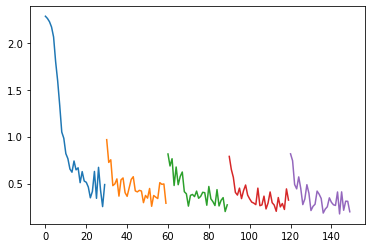

In [16]:
loss_plot(ewc_total_loss)

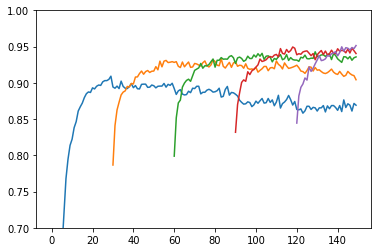

In [17]:
accuracy_plot(ewc_prec)

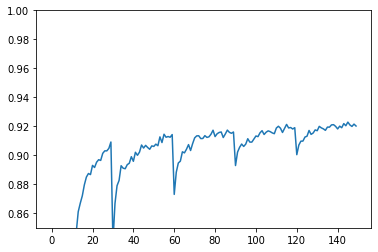

In [44]:
avg_precision_plot([ewc_prec])

In [18]:
lamda = 100
mlp_consolidation_100 = MLP(
    DATASET_CONFIGS['mnist']['size']**2,
    DATASET_CONFIGS['mnist']['classes'],
    hidden_size,
    hidden_layer_num,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.xavier_initialize(mlp_consolidation_100)

# run the standard experiment.
consolidate = True
ewc_prec_100, ewc_total_loss_100, ewc_ce_loss_100, ewc_ewc_loss_100 =train(
    mlp_consolidation_100, train_datasets, test_datasets,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)

=> task: 1/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.1875 | loss => ce: 2.286 / ewc: 0.0 / total: 2.286: : 469it [00:30, 15.32it/s]
=> task: 1/5 | epoch: 2/30 | progress: [256/60000] (0%) | prec: 0.125 | loss => ce: 2.292 / ewc: 0.0 / total: 2.292: : 2it [00:00, 12.39it/s]

Test Accuracy {1: [0.299560546875]}
total loss {1: [2.285710573196411]} cross entropy {1: [2.285710573196411]} ewc {1: [0.0]}


=> task: 1/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.1979 | loss => ce: 2.254 / ewc: 0.0 / total: 2.254: : 469it [00:29, 15.76it/s]
=> task: 1/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.2422 | loss => ce: 2.262 / ewc: 0.0 / total: 2.262: : 2it [00:00, 13.83it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875]}
total loss {1: [2.285710573196411, 2.2538070678710938]} cross entropy {1: [2.285710573196411, 2.2538070678710938]} ewc {1: [0.0, 0.0]}


=> task: 1/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.3021 | loss => ce: 2.232 / ewc: 0.0 / total: 2.232: : 469it [00:29, 15.74it/s]
=> task: 1/5 | epoch: 4/30 | progress: [256/60000] (0%) | prec: 0.3359 | loss => ce: 2.217 / ewc: 0.0 / total: 2.217: : 2it [00:00, 12.01it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416]} ewc {1: [0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.3958 | loss => ce: 2.174 / ewc: 0.0 / total: 2.174: : 469it [00:30, 15.28it/s]
=> task: 1/5 | epoch: 5/30 | progress: [256/60000] (0%) | prec: 0.3906 | loss => ce: 2.176 / ewc: 0.0 / total: 2.176: : 1it [00:00,  9.95it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174]} ewc {1: [0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.4583 | loss => ce: 2.085 / ewc: 0.0 / total: 2.085: : 469it [00:33, 13.91it/s]
=> task: 1/5 | epoch: 6/30 | progress: [256/60000] (0%) | prec: 0.3516 | loss => ce: 2.1 / ewc: 0.0 / total: 2.1: : 2it [00:00, 11.41it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.3854 | loss => ce: 1.927 / ewc: 0.0 / total: 1.927: : 469it [00:33, 13.91it/s]
=> task: 1/5 | epoch: 7/30 | progress: [128/60000] (0%) | prec: 0.3984 | loss => ce: 1.948 / ewc: 0.0 / total: 1.948: : 0it [00:00, ?it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.5312 | loss => ce: 1.622 / ewc: 0.0 / total: 1.622: : 469it [00:34, 13.45it/s]
=> task: 1/5 | epoch: 8/30 | progress: [256/60000] (0%) | prec: 0.5234 | loss => ce: 1.638 / ewc: 0.0 / total: 1.638: : 2it [00:00, 12.65it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.5417 | loss => ce: 1.438 / ewc: 0.0 / total: 1.438: : 469it [00:36, 13.02it/s]
=> task: 1/5 | epoch: 9/30 | progress: [256/60000] (0%) | prec: 0.5391 | loss => ce: 1.383 / ewc: 0.0 / total: 1.383: : 2it [00:00, 12.03it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.6354 | loss => ce: 1.127 / ewc: 0.0 / total: 1.127: : 469it [00:31, 14.83it/s] 
=> task: 1/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.6406 | loss => ce: 1.09 / ewc: 0.0 / total: 1.09: : 2it [00:00, 11.89it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.7083 | loss => ce: 0.9515 / ewc: 0.0 / total: 0.9515: : 469it [00:29, 15.86it/s]
=> task: 1/5 | epoch: 11/30 | progress: [256/60000] (0%) | prec: 0.7109 | loss => ce: 0.9954 / ewc: 0.0 / total: 0.9954: : 2it [00:00, 13.41it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.7292 | loss => ce: 0.7788 / ewc: 0.0 / total: 0.7788: : 469it [00:30, 15.57it/s]
=> task: 1/5 | epoch: 12/30 | progress: [256/60000] (0%) | prec: 0.7188 | loss => ce: 0.9274 / ewc: 0.0 / total: 0.9274: : 2it [00:00, 14.29it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.7396 | loss => ce: 0.8433 / ewc: 0.0 / total: 0.8433: : 469it [00:30, 15.24it/s]
=> task: 1/5 | epoch: 13/30 | progress: [256/60000] (0%) | prec: 0.7578 | loss => ce: 0.7507 / ewc: 0.0 / total: 0.7507: : 2it [00:00, 12.34it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.8125 | loss => ce: 0.6031 / ewc: 0.0 / total: 0.6031: : 469it [00:29, 15.81it/s]
=> task: 1/5 | epoch: 14/30 | progress: [256/60000] (0%) | prec: 0.7266 | loss => ce: 0.734 / ewc: 0.0 / total: 0.734: : 2it [00:00, 12.07it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.7604 | loss => ce: 0.8001 / ewc: 0.0 / total: 0.8001: : 469it [00:29, 15.74it/s]
=> task: 1/5 | epoch: 15/30 | progress: [128/60000] (0%) | prec: 0.8516 | loss => ce: 0.5414 / ewc: 0.0 / total: 0.5414: : 0it [00:00, ?it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.5369 / ewc: 0.0 / total: 0.5369: : 469it [00:30, 15.53it/s]
=> task: 1/5 | epoch: 16/30 | progress: [256/60000] (0%) | prec: 0.8203 | loss => ce: 0.6173 / ewc: 0.0 / total: 0.6173: : 2it [00:00, 11.92it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


=> task: 1/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.7812 | loss => ce: 0.6114 / ewc: 0.0 / total: 0.6114: : 469it [00:29, 15.85it/s]
=> task: 1/5 | epoch: 17/30 | progress: [256/60000] (0%) | prec: 0.7266 | loss => ce: 0.7609 / ewc: 0.0 / total: 0.7609: : 2it [00:00, 13.48it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474]} ewc {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

=> task: 1/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.4855 / ewc: 0.0 / total: 0.4855: : 469it [00:29, 15.85it/s]
=> task: 1/5 | epoch: 18/30 | progress: [256/60000] (0%) | prec: 0.8594 | loss => ce: 0.5224 / ewc: 0.0 / total: 0.5224: : 2it [00:00, 12.33it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114]} ewc {1:

=> task: 1/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.4924 / ewc: 0.0 / total: 0.4924: : 469it [00:29, 15.83it/s]
=> task: 1/5 | epoch: 19/30 | progress: [256/60000] (0%) | prec: 0.8203 | loss => ce: 0.6567 / ewc: 0.0 / total: 0.6567: : 2it [00:00, 12.24it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.611360669

=> task: 1/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.4412 / ewc: 0.0 / total: 0.4412: : 469it [00:29, 16.04it/s]
=> task: 1/5 | epoch: 20/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.4829 / ewc: 0.0 / total: 0.4829: : 2it [00:00, 14.20it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.800059378147

=> task: 1/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.8229 | loss => ce: 0.4654 / ewc: 0.0 / total: 0.4654: : 469it [00:28, 16.30it/s]
=> task: 1/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.4819 / ewc: 0.0 / total: 0.4819: : 2it [00:00, 13.92it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475

=> task: 1/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3782 / ewc: 0.0 / total: 0.3782: : 469it [00:28, 16.35it/s]
=> task: 1/5 | epoch: 22/30 | progress: [256/60000] (0%) | prec: 0.8281 | loss => ce: 0.5202 / ewc: 0.0 / total: 0.5202: : 2it [00:00, 13.83it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213, 0.3781643211841583]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7

=> task: 1/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.4356 / ewc: 0.0 / total: 0.4356: : 469it [00:28, 16.27it/s]
=> task: 1/5 | epoch: 23/30 | progress: [256/60000] (0%) | prec: 0.8203 | loss => ce: 0.4566 / ewc: 0.0 / total: 0.4566: : 2it [00:00, 13.98it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213, 0.3781643211841583, 0.4355645179748535]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.12747

=> task: 1/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.4451 / ewc: 0.0 / total: 0.4451: : 469it [00:28, 16.22it/s]
=> task: 1/5 | epoch: 24/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.4262 / ewc: 0.0 / total: 0.4262: : 2it [00:00, 13.88it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213, 0.3781643211841583, 0.4355645179748535, 0.44514867663383484]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784

=> task: 1/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.5226 / ewc: 0.0 / total: 0.5226: : 469it [00:29, 16.04it/s]
=> task: 1/5 | epoch: 25/30 | progress: [256/60000] (0%) | prec: 0.8516 | loss => ce: 0.5134 / ewc: 0.0 / total: 0.5134: : 2it [00:00, 13.95it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213, 0.3781643211841583, 0.4355645179748535, 0.44514867663383484, 0.522614061832428]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.0849747657775

=> task: 1/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3276 / ewc: 0.0 / total: 0.3276: : 469it [00:29, 16.03it/s]
=> task: 1/5 | epoch: 26/30 | progress: [384/60000] (1%) | prec: 0.8516 | loss => ce: 0.422 / ewc: 0.0 / total: 0.422: : 2it [00:00, 14.61it/s]  

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213, 0.3781643211841583, 0.4355645179748535, 0.44514867663383484, 0.522614061832428, 0.3275802433490753]} cross entropy {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416,

=> task: 1/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3595 / ewc: 0.0 / total: 0.3595: : 469it [00:28, 16.29it/s]
=> task: 1/5 | epoch: 27/30 | progress: [384/60000] (1%) | prec: 0.8906 | loss => ce: 0.4107 / ewc: 0.0 / total: 0.4107: : 2it [00:00, 14.62it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213, 0.3781643211841583, 0.4355645179748535, 0.44514867663383484, 0.522614061832428, 0.3275802433490753, 0.35946643352508545]} cross entropy {1: [2.285710573196411, 2.

=> task: 1/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.6356 / ewc: 0.0 / total: 0.6356: : 469it [00:28, 16.22it/s]
=> task: 1/5 | epoch: 28/30 | progress: [384/60000] (1%) | prec: 0.8438 | loss => ce: 0.486 / ewc: 0.0 / total: 0.486: : 2it [00:00, 14.44it/s]  

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213, 0.3781643211841583, 0.4355645179748535, 0.44514867663383484, 0.522614061832428, 0.3275802433490753, 0.35946643352508545, 0.6355512738227844]} cros

=> task: 1/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.4578 / ewc: 0.0 / total: 0.4578: : 469it [00:28, 16.29it/s]
=> task: 1/5 | epoch: 29/30 | progress: [256/60000] (0%) | prec: 0.8516 | loss => ce: 0.4623 / ewc: 0.0 / total: 0.4623: : 2it [00:00, 14.11it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213, 0.3781643211841583, 0.4355645179748535, 0.44514867663383484, 0.522614061832428, 0.3275802433490753, 0.35946643352508545, 0.6355512

=> task: 1/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.4446 / ewc: 0.0 / total: 0.4446: : 469it [00:29, 15.95it/s]
=> task: 1/5 | epoch: 30/30 | progress: [256/60000] (0%) | prec: 0.8438 | loss => ce: 0.4778 / ewc: 0.0 / total: 0.4778: : 2it [00:00, 11.85it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213, 0.3781643211841583, 0.4355645179748535, 0.44514867663383484, 0.522614061832428, 0.3275802433490753, 0.359466433525085

=> task: 1/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.8021 | loss => ce: 0.6684 / ewc: 0.0 / total: 0.6684: : 469it [00:29, 16.17it/s]


Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213, 0.3781643211841583, 0.4355645179748535, 0.44514867663383484, 0.522614061832428, 0.3275802433490753, 0.359

0it [00:00, ?it/s]

 Done!


=> task: 2/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.6458 | loss => ce: 0.9745 / ewc: 0.01393 / total: 0.9884: : 469it [00:34, 13.61it/s]
=> task: 2/5 | epoch: 2/30 | progress: [256/60000] (0%) | prec: 0.7188 | loss => ce: 0.899 / ewc: 0.01399 / total: 0.9129: : 2it [00:00, 13.11it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375], 2: [0.786865234375]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213, 0.3781643211841583, 0.4355645179748535, 0.44514867663383484, 0.52261

=> task: 2/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.7083 | loss => ce: 0.7855 / ewc: 0.02381 / total: 0.8093: : 469it [00:32, 14.61it/s]
=> task: 2/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.7891 | loss => ce: 0.761 / ewc: 0.02387 / total: 0.7848: : 2it [00:00, 12.78it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375], 2: [0.786865234375, 0.835693359375]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213, 0.3781643211841583, 0.43556451797485

=> task: 2/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.7604 | loss => ce: 0.6893 / ewc: 0.03021 / total: 0.7195: : 469it [00:32, 14.57it/s]
=> task: 2/5 | epoch: 4/30 | progress: [256/60000] (0%) | prec: 0.7734 | loss => ce: 0.7169 / ewc: 0.03023 / total: 0.7471: : 2it [00:00, 12.26it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625], 2: [0.786865234375, 0.835693359375, 0.86865234375]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.44124844670295715, 0.4654219150543213, 0.378

=> task: 2/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.75 | loss => ce: 0.7071 / ewc: 0.03495 / total: 0.742: : 469it [00:32, 14.50it/s]   
=> task: 2/5 | epoch: 5/30 | progress: [256/60000] (0%) | prec: 0.7891 | loss => ce: 0.6858 / ewc: 0.03496 / total: 0.7207: : 2it [00:00, 13.35it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.49242305755615234, 0.4412484467029571

=> task: 2/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.75 | loss => ce: 0.6835 / ewc: 0.03867 / total: 0.7221: : 469it [00:32, 14.65it/s]  
=> task: 2/5 | epoch: 6/30 | progress: [256/60000] (0%) | prec: 0.8359 | loss => ce: 0.587 / ewc: 0.03867 / total: 0.6257: : 2it [00:00, 12.45it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4855177104473114, 0.492423057

=> task: 2/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.7917 | loss => ce: 0.6468 / ewc: 0.04173 / total: 0.6885: : 469it [00:32, 14.63it/s]
=> task: 2/5 | epoch: 7/30 | progress: [256/60000] (0%) | prec: 0.8594 | loss => ce: 0.418 / ewc: 0.04172 / total: 0.4597: : 2it [00:00, 12.82it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782593, 0.6113606691360474, 0.4

=> task: 2/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4989 / ewc: 0.04427 / total: 0.5432: : 469it [00:32, 14.57it/s]
=> task: 2/5 | epoch: 8/30 | progress: [256/60000] (0%) | prec: 0.8203 | loss => ce: 0.609 / ewc: 0.04429 / total: 0.6533: : 2it [00:00, 13.06it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8000593781471252, 0.5368999242782

=> task: 2/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.8125 | loss => ce: 0.6616 / ewc: 0.04655 / total: 0.7082: : 469it [00:32, 14.62it/s]
=> task: 2/5 | epoch: 9/30 | progress: [256/60000] (0%) | prec: 0.8438 | loss => ce: 0.619 / ewc: 0.04653 / total: 0.6656: : 2it [00:00, 12.75it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.8432862758636475, 0.603063702583313, 0.8

=> task: 2/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.3968 / ewc: 0.04838 / total: 0.4452: : 469it [00:32, 14.65it/s]
=> task: 2/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.8047 | loss => ce: 0.5562 / ewc: 0.04841 / total: 0.6046: : 2it [00:00, 12.98it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374, 0.7787525057792664, 0.84328627

=> task: 2/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.8229 | loss => ce: 0.6989 / ewc: 0.05004 / total: 0.7489: : 469it [00:32, 14.65it/s]
=> task: 2/5 | epoch: 11/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.4097 / ewc: 0.05003 / total: 0.4598: : 2it [00:00, 12.93it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.1274787187576294, 0.9515348076820374,

=> task: 2/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.4862 / ewc: 0.05144 / total: 0.5377: : 469it [00:32, 14.61it/s] 
=> task: 2/5 | epoch: 12/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.4323 / ewc: 0.05145 / total: 0.4837: : 2it [00:00, 12.64it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0.903564453125]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134888, 1.438220500946045, 1.12747

=> task: 2/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.5171 / ewc: 0.0527 / total: 0.5698: : 469it [00:31, 14.66it/s] 
=> task: 2/5 | epoch: 13/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.4483 / ewc: 0.05269 / total: 0.5009: : 2it [00:00, 13.06it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0.903564453125, 0.906005859375]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.9274225234985352, 1.6223784685134

=> task: 2/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.7917 | loss => ce: 0.7379 / ewc: 0.05397 / total: 0.7919: : 469it [00:31, 14.68it/s]
=> task: 2/5 | epoch: 14/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.3663 / ewc: 0.05397 / total: 0.4203: : 2it [00:00, 12.36it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0.903564453125, 0.906005859375, 0.90283203125]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381378174, 2.084974765777588, 1.92

=> task: 2/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.4812 / ewc: 0.05507 / total: 0.5363: : 469it [00:32, 14.61it/s]
=> task: 2/5 | epoch: 15/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.3518 / ewc: 0.05508 / total: 0.4068: : 2it [00:00, 12.56it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0.903564453125, 0.906005859375, 0.90283203125, 0.905517578125]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2.2319490909576416, 2.1736271381

=> task: 2/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.4858 / ewc: 0.05599 / total: 0.5418: : 469it [00:32, 14.65it/s]
=> task: 2/5 | epoch: 16/30 | progress: [256/60000] (0%) | prec: 0.8438 | loss => ce: 0.4782 / ewc: 0.056 / total: 0.5342: : 2it [00:00, 12.32it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0.903564453125, 0.906005859375, 0.90283203125, 0.905517578125, 0.91748046875]}
total loss {1: [2.285710573196411, 2.2538070678710938, 2

=> task: 2/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.3677 / ewc: 0.05694 / total: 0.4246: : 469it [00:32, 14.58it/s] 
=> task: 2/5 | epoch: 17/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.34 / ewc: 0.05695 / total: 0.397: : 2it [00:00, 12.24it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0.903564453125, 0.906005859375, 0.90283203125, 0.905517578125, 0.91748046875, 0.912109375]}
total loss {1: [2.285710573

=> task: 2/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.4737 / ewc: 0.0578 / total: 0.5315: : 469it [00:32, 14.61it/s] 
=> task: 2/5 | epoch: 18/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.2935 / ewc: 0.0578 / total: 0.3513: : 2it [00:00, 13.55it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0.903564453125, 0.906005859375, 0.90283203125, 0.905517578125, 0.91748046875, 0.912109375, 0.91040039062

=> task: 2/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.7917 | loss => ce: 0.6841 / ewc: 0.05856 / total: 0.7426: : 469it [00:32, 14.65it/s]
=> task: 2/5 | epoch: 19/30 | progress: [256/60000] (0%) | prec: 0.8594 | loss => ce: 0.4602 / ewc: 0.05856 / total: 0.5188: : 2it [00:00, 13.16it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0.903564453125, 0.906005859375, 0.90283203125, 0.905517578125, 0.91748046875, 0.91210937

=> task: 2/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3976 / ewc: 0.05935 / total: 0.4569: : 469it [00:31, 14.66it/s]
=> task: 2/5 | epoch: 20/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.3663 / ewc: 0.05935 / total: 0.4257: : 2it [00:00, 12.22it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0.903564453125, 0.906005859375, 0.90283203125, 0.905517578125, 0.9174804

=> task: 2/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3125 / ewc: 0.06006 / total: 0.3726: : 469it [00:32, 14.63it/s]
=> task: 2/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.4061 / ewc: 0.06006 / total: 0.4661: : 2it [00:00, 12.23it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0.903564453125, 0.906005859375, 0.90283203125, 0.905517578

=> task: 2/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.3001 / ewc: 0.06074 / total: 0.3609: : 469it [00:32, 14.55it/s] 
=> task: 2/5 | epoch: 22/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.3976 / ewc: 0.06075 / total: 0.4583: : 2it [00:00, 12.90it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0.903564453125, 0.906005859375, 0.902832031

=> task: 2/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.4823 / ewc: 0.06138 / total: 0.5437: : 469it [00:32, 14.64it/s]
=> task: 2/5 | epoch: 23/30 | progress: [256/60000] (0%) | prec: 0.9453 | loss => ce: 0.2434 / ewc: 0.06138 / total: 0.3048: : 2it [00:00, 13.02it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0.903564453125, 0.906005859375

=> task: 2/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.7917 | loss => ce: 0.6981 / ewc: 0.06198 / total: 0.7601: : 469it [00:31, 14.66it/s]
=> task: 2/5 | epoch: 24/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.3105 / ewc: 0.06197 / total: 0.3725: : 2it [00:00, 12.29it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0.903564453125,

=> task: 2/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2605 / ewc: 0.06259 / total: 0.3231: : 469it [00:32, 14.57it/s]
=> task: 2/5 | epoch: 25/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.2809 / ewc: 0.0626 / total: 0.3435: : 2it [00:00, 13.07it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.896240234375, 0

=> task: 2/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3328 / ewc: 0.06327 / total: 0.396: : 469it [00:32, 14.63it/s] 
=> task: 2/5 | epoch: 26/30 | progress: [256/60000] (0%) | prec: 0.8359 | loss => ce: 0.4228 / ewc: 0.06327 / total: 0.4861: : 2it [00:00, 12.50it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.899169921875, 0.8962

=> task: 2/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.4086 / ewc: 0.06375 / total: 0.4723: : 469it [00:32, 14.65it/s]
=> task: 2/5 | epoch: 27/30 | progress: [256/60000] (0%) | prec: 0.8438 | loss => ce: 0.5603 / ewc: 0.06374 / total: 0.624: : 2it [00:00, 11.77it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.892822265625, 0.8991

=> task: 2/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.4612 / ewc: 0.06426 / total: 0.5254: : 469it [00:32, 14.62it/s]
=> task: 2/5 | epoch: 28/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.3652 / ewc: 0.06427 / total: 0.4295: : 2it [00:00, 12.22it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.892578125, 0.89282

=> task: 2/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.267 / ewc: 0.06477 / total: 0.3318: : 469it [00:32, 14.59it/s] 
=> task: 2/5 | epoch: 29/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.3042 / ewc: 0.06478 / total: 0.3689: : 2it [00:00, 13.15it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.88427734375, 0.89

=> task: 2/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.3614 / ewc: 0.06525 / total: 0.4266: : 469it [00:31, 14.66it/s]
=> task: 2/5 | epoch: 30/30 | progress: [256/60000] (0%) | prec: 0.9453 | loss => ce: 0.2186 / ewc: 0.06527 / total: 0.2838: : 2it [00:00, 12.57it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.885009765625, 0.8

=> task: 2/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3207 / ewc: 0.06573 / total: 0.3864: : 469it [00:32, 14.65it/s]


Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.88037109375, 0.8

0it [00:00, ?it/s]

 Done!


=> task: 3/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.7812 | loss => ce: 0.719 / ewc: 0.01743 / total: 0.7364: : 469it [00:38, 12.19it/s] 
=> task: 3/5 | epoch: 2/30 | progress: [256/60000] (0%) | prec: 0.7344 | loss => ce: 0.901 / ewc: 0.01749 / total: 0.9185: : 2it [00:00, 14.11it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625], 2: [0.786865234375, 0.835693359375, 0.86865234375, 0.880

=> task: 3/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.7917 | loss => ce: 0.6276 / ewc: 0.0269 / total: 0.6545: : 469it [01:05,  7.14it/s] 
=> task: 3/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.5259 / ewc: 0.02691 / total: 0.5528: : 2it [00:00, 13.77it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125], 2: [0.786865234375, 0.835693359375, 0.868

=> task: 3/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.8021 | loss => ce: 0.6398 / ewc: 0.03248 / total: 0.6723: : 469it [06:50,  1.14it/s]
=> task: 3/5 | epoch: 4/30 | progress: [256/60000] (0%) | prec: 0.8047 | loss => ce: 0.5884 / ewc: 0.03248 / total: 0.6209: : 2it [00:00, 11.83it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875], 2: [0.786865234375, 0.8356

=> task: 3/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.4124 / ewc: 0.0362 / total: 0.4486: : 469it [00:33, 14.12it/s]  
=> task: 3/5 | epoch: 5/30 | progress: [256/60000] (0%) | prec: 0.8359 | loss => ce: 0.5461 / ewc: 0.03622 / total: 0.5823: : 2it [00:00, 11.97it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625], 2: [0.7868

=> task: 3/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.5348 / ewc: 0.0389 / total: 0.5737: : 469it [00:32, 14.28it/s]
=> task: 3/5 | epoch: 6/30 | progress: [256/60000] (0%) | prec: 0.8281 | loss => ce: 0.5359 / ewc: 0.03893 / total: 0.5748: : 2it [00:00, 10.16it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.8229 | loss => ce: 0.4973 / ewc: 0.04127 / total: 0.5386: : 469it [00:32, 14.23it/s]
=> task: 3/5 | epoch: 7/30 | progress: [256/60000] (0%) | prec: 0.8516 | loss => ce: 0.4375 / ewc: 0.04128 / total: 0.4787: : 2it [00:00, 11.51it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.414 / ewc: 0.04316 / total: 0.4571: : 469it [00:32, 14.29it/s] 
=> task: 3/5 | epoch: 8/30 | progress: [256/60000] (0%) | prec: 0.8359 | loss => ce: 0.4322 / ewc: 0.04317 / total: 0.4754: : 2it [00:00, 12.49it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3315 / ewc: 0.04462 / total: 0.3762: : 469it [00:32, 14.27it/s]
=> task: 3/5 | epoch: 9/30 | progress: [256/60000] (0%) | prec: 0.8203 | loss => ce: 0.4816 / ewc: 0.04464 / total: 0.5263: : 2it [00:00, 12.97it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.8229 | loss => ce: 0.4846 / ewc: 0.04596 / total: 0.5305: : 469it [00:32, 14.34it/s]
=> task: 3/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.8594 | loss => ce: 0.3964 / ewc: 0.04597 / total: 0.4424: : 2it [00:00, 12.99it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3922 / ewc: 0.04709 / total: 0.4393: : 469it [00:32, 14.29it/s]
=> task: 3/5 | epoch: 11/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.3396 / ewc: 0.04709 / total: 0.3867: : 2it [00:00, 11.94it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3265 / ewc: 0.04824 / total: 0.3747: : 469it [00:33, 14.20it/s]
=> task: 3/5 | epoch: 12/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.4561 / ewc: 0.04826 / total: 0.5043: : 2it [00:00, 12.55it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4081 / ewc: 0.04925 / total: 0.4573: : 469it [00:33, 14.20it/s]
=> task: 3/5 | epoch: 13/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.3523 / ewc: 0.04926 / total: 0.4016: : 2it [00:00, 11.51it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.3698 / ewc: 0.05012 / total: 0.42: : 469it [00:33, 14.19it/s]   
=> task: 3/5 | epoch: 14/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.3473 / ewc: 0.05013 / total: 0.3974: : 2it [00:00, 12.94it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.3783 / ewc: 0.05099 / total: 0.4293: : 469it [00:32, 14.41it/s]
=> task: 3/5 | epoch: 15/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.3494 / ewc: 0.05099 / total: 0.4004: : 2it [00:00, 12.08it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.4351 / ewc: 0.05176 / total: 0.4868: : 469it [00:32, 14.29it/s]
=> task: 3/5 | epoch: 16/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.3954 / ewc: 0.05176 / total: 0.4472: : 2it [00:00, 12.33it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3402 / ewc: 0.05256 / total: 0.3927: : 469it [00:32, 14.26it/s]
=> task: 3/5 | epoch: 17/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.3246 / ewc: 0.05258 / total: 0.3771: : 2it [00:00, 12.47it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.4158 / ewc: 0.05328 / total: 0.469: : 469it [00:32, 14.24it/s] 
=> task: 3/5 | epoch: 18/30 | progress: [256/60000] (0%) | prec: 0.8359 | loss => ce: 0.4914 / ewc: 0.05327 / total: 0.5447: : 2it [00:00, 12.27it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3895 / ewc: 0.05393 / total: 0.4434: : 469it [00:32, 14.29it/s]
=> task: 3/5 | epoch: 19/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.4027 / ewc: 0.05392 / total: 0.4566: : 2it [00:00, 12.59it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.3787 / ewc: 0.05452 / total: 0.4332: : 469it [00:32, 14.33it/s]
=> task: 3/5 | epoch: 20/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.2884 / ewc: 0.05452 / total: 0.343: : 2it [00:00, 12.72it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4165 / ewc: 0.05519 / total: 0.4717: : 469it [00:32, 14.22it/s]
=> task: 3/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.3473 / ewc: 0.05519 / total: 0.4025: : 2it [00:00, 12.17it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2855 / ewc: 0.05585 / total: 0.3413: : 469it [00:32, 14.34it/s]
=> task: 3/5 | epoch: 22/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.3714 / ewc: 0.05586 / total: 0.4273: : 2it [00:00, 12.44it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.2982 / ewc: 0.05643 / total: 0.3547: : 469it [00:32, 14.31it/s]
=> task: 3/5 | epoch: 23/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.3796 / ewc: 0.05644 / total: 0.436: : 2it [00:00, 12.78it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.3193 / ewc: 0.05692 / total: 0.3762: : 469it [00:32, 14.31it/s]
=> task: 3/5 | epoch: 24/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.3369 / ewc: 0.05693 / total: 0.3938: : 2it [00:00, 12.68it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3855 / ewc: 0.05748 / total: 0.443: : 469it [00:32, 14.34it/s] 
=> task: 3/5 | epoch: 25/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.3524 / ewc: 0.05748 / total: 0.4098: : 2it [00:00, 12.43it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.3953 / ewc: 0.05802 / total: 0.4533: : 469it [00:32, 14.31it/s]
=> task: 3/5 | epoch: 26/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.379 / ewc: 0.05802 / total: 0.4371: : 2it [00:00, 12.05it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.3117 / ewc: 0.05851 / total: 0.3702: : 469it [00:32, 14.39it/s] 
=> task: 3/5 | epoch: 27/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.346 / ewc: 0.05851 / total: 0.4045: : 2it [00:00, 12.82it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2858 / ewc: 0.05899 / total: 0.3447: : 469it [00:32, 14.24it/s]
=> task: 3/5 | epoch: 28/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.347 / ewc: 0.059 / total: 0.406: : 2it [00:00, 12.43it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.2736 / ewc: 0.05955 / total: 0.3331: : 469it [00:32, 14.32it/s]
=> task: 3/5 | epoch: 29/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.4224 / ewc: 0.05955 / total: 0.482: : 2it [00:00, 12.23it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.4104 / ewc: 0.0601 / total: 0.4705: : 469it [00:32, 14.26it/s] 
=> task: 3/5 | epoch: 30/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.2657 / ewc: 0.06011 / total: 0.3258: : 2it [00:00, 13.28it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 3/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.1897 / ewc: 0.06057 / total: 0.2503: : 469it [00:32, 14.35it/s]


Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

0it [00:00, ?it/s]

 Done!


=> task: 4/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.7083 | loss => ce: 0.7687 / ewc: 0.01846 / total: 0.7872: : 469it [00:47,  9.78it/s]
=> task: 4/5 | epoch: 2/30 | progress: [128/60000] (0%) | prec: 0.7422 | loss => ce: 0.7511 / ewc: 0.01849 / total: 0.7695: : 1it [00:00,  9.97it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.8021 | loss => ce: 0.6268 / ewc: 0.02608 / total: 0.6529: : 469it [00:45, 10.27it/s]
=> task: 4/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.5501 / ewc: 0.02611 / total: 0.5762: : 2it [00:00, 11.62it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.7917 | loss => ce: 0.5979 / ewc: 0.03052 / total: 0.6284: : 469it [00:42, 11.10it/s]
=> task: 4/5 | epoch: 4/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.4763 / ewc: 0.03054 / total: 0.5069: : 2it [00:00, 10.90it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.442 / ewc: 0.03352 / total: 0.4755: : 469it [00:42, 11.02it/s] 
=> task: 4/5 | epoch: 5/30 | progress: [256/60000] (0%) | prec: 0.7734 | loss => ce: 0.6601 / ewc: 0.03353 / total: 0.6936: : 2it [00:00, 10.55it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.8021 | loss => ce: 0.6155 / ewc: 0.03573 / total: 0.6512: : 469it [00:44, 10.60it/s]
=> task: 4/5 | epoch: 6/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.5771 / ewc: 0.03572 / total: 0.6129: : 2it [00:00, 11.29it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.4526 / ewc: 0.03742 / total: 0.49: : 469it [00:43, 10.72it/s]  
=> task: 4/5 | epoch: 7/30 | progress: [256/60000] (0%) | prec: 0.8359 | loss => ce: 0.5136 / ewc: 0.03743 / total: 0.5511: : 2it [00:00, 10.75it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2761 / ewc: 0.03878 / total: 0.3148: : 469it [00:42, 10.97it/s]
=> task: 4/5 | epoch: 8/30 | progress: [128/60000] (0%) | prec: 0.8281 | loss => ce: 0.5101 / ewc: 0.03878 / total: 0.5489: : 1it [00:00,  7.90it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.428 / ewc: 0.04001 / total: 0.468: : 469it [00:44, 10.51it/s]  
=> task: 4/5 | epoch: 9/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.3764 / ewc: 0.04002 / total: 0.4164: : 2it [00:00, 11.45it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.8229 | loss => ce: 0.478 / ewc: 0.04102 / total: 0.5191: : 469it [00:44, 10.65it/s] 
=> task: 4/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.336 / ewc: 0.04102 / total: 0.377: : 2it [00:00, 11.59it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2627 / ewc: 0.0419 / total: 0.3046: : 469it [00:42, 11.02it/s]
=> task: 4/5 | epoch: 11/30 | progress: [256/60000] (0%) | prec: 0.9453 | loss => ce: 0.3632 / ewc: 0.04191 / total: 0.4051: : 2it [00:00, 10.61it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.3583 / ewc: 0.0428 / total: 0.4011: : 469it [00:42, 10.96it/s]
=> task: 4/5 | epoch: 12/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.3236 / ewc: 0.0428 / total: 0.3664: : 2it [00:00, 11.35it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2799 / ewc: 0.04357 / total: 0.3235: : 469it [00:44, 10.52it/s]
=> task: 4/5 | epoch: 13/30 | progress: [128/60000] (0%) | prec: 0.875 | loss => ce: 0.4487 / ewc: 0.04357 / total: 0.4923: : 1it [00:00,  8.78it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2553 / ewc: 0.04424 / total: 0.2995: : 469it [00:43, 10.82it/s]
=> task: 4/5 | epoch: 14/30 | progress: [128/60000] (0%) | prec: 0.8984 | loss => ce: 0.3831 / ewc: 0.04425 / total: 0.4274: : 1it [00:00,  8.58it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2476 / ewc: 0.04492 / total: 0.2925: : 469it [00:43, 10.72it/s]
=> task: 4/5 | epoch: 15/30 | progress: [128/60000] (0%) | prec: 0.9375 | loss => ce: 0.2038 / ewc: 0.04492 / total: 0.2487: : 1it [00:00,  5.81it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.3705 / ewc: 0.0456 / total: 0.4161: : 469it [00:44, 10.44it/s]
=> task: 4/5 | epoch: 16/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.4307 / ewc: 0.0456 / total: 0.4763: : 2it [00:00, 10.70it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.274 / ewc: 0.04623 / total: 0.3202: : 469it [00:45, 10.41it/s] 
=> task: 4/5 | epoch: 17/30 | progress: [256/60000] (0%) | prec: 0.9453 | loss => ce: 0.2438 / ewc: 0.04623 / total: 0.29: : 2it [00:00, 10.98it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3517 / ewc: 0.04682 / total: 0.3986: : 469it [00:43, 10.72it/s]
=> task: 4/5 | epoch: 18/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.3754 / ewc: 0.04683 / total: 0.4222: : 2it [00:00, 11.48it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.209 / ewc: 0.04742 / total: 0.2564: : 469it [00:43, 10.85it/s] 
=> task: 4/5 | epoch: 19/30 | progress: [128/60000] (0%) | prec: 0.8594 | loss => ce: 0.3804 / ewc: 0.04742 / total: 0.4278: : 1it [00:00,  6.40it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3045 / ewc: 0.0479 / total: 0.3525: : 469it [00:44, 10.63it/s] 
=> task: 4/5 | epoch: 20/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.4027 / ewc: 0.04791 / total: 0.4506: : 2it [00:00, 11.01it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3818 / ewc: 0.04848 / total: 0.4302: : 469it [00:45, 10.35it/s]
=> task: 4/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.4139 / ewc: 0.04848 / total: 0.4623: : 2it [00:00, 10.65it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2633 / ewc: 0.04904 / total: 0.3123: : 469it [00:43, 10.88it/s]
=> task: 4/5 | epoch: 22/30 | progress: [128/60000] (0%) | prec: 0.9375 | loss => ce: 0.2506 / ewc: 0.04903 / total: 0.2996: : 1it [00:00,  8.98it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4173 / ewc: 0.04955 / total: 0.4668: : 469it [00:42, 11.09it/s]
=> task: 4/5 | epoch: 23/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.3206 / ewc: 0.04955 / total: 0.3702: : 2it [00:00, 10.81it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2621 / ewc: 0.05004 / total: 0.3122: : 469it [00:41, 11.42it/s]
=> task: 4/5 | epoch: 24/30 | progress: [256/60000] (0%) | prec: 0.9609 | loss => ce: 0.2044 / ewc: 0.05004 / total: 0.2544: : 2it [00:00, 10.80it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2883 / ewc: 0.05052 / total: 0.3388: : 469it [00:41, 11.36it/s]
=> task: 4/5 | epoch: 25/30 | progress: [128/60000] (0%) | prec: 0.9453 | loss => ce: 0.2417 / ewc: 0.05052 / total: 0.2922: : 0it [00:00, ?it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.278 / ewc: 0.05099 / total: 0.329: : 469it [00:42, 10.95it/s]  
=> task: 4/5 | epoch: 26/30 | progress: [256/60000] (0%) | prec: 0.9453 | loss => ce: 0.193 / ewc: 0.05099 / total: 0.2439: : 2it [00:00, 11.76it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3048 / ewc: 0.05142 / total: 0.3563: : 469it [00:44, 10.53it/s]
=> task: 4/5 | epoch: 27/30 | progress: [256/60000] (0%) | prec: 0.8516 | loss => ce: 0.4273 / ewc: 0.05143 / total: 0.4788: : 2it [00:00, 10.78it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2396 / ewc: 0.05185 / total: 0.2914: : 469it [00:45, 10.21it/s]
=> task: 4/5 | epoch: 28/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.2421 / ewc: 0.05185 / total: 0.294: : 2it [00:00, 10.93it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.1975 / ewc: 0.05229 / total: 0.2498: : 469it [00:41, 11.18it/s]
=> task: 4/5 | epoch: 29/30 | progress: [128/60000] (0%) | prec: 0.9219 | loss => ce: 0.2677 / ewc: 0.05229 / total: 0.32: : 1it [00:00,  8.64it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.222 / ewc: 0.05275 / total: 0.2747: : 469it [00:43, 10.82it/s] 
=> task: 4/5 | epoch: 30/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.358 / ewc: 0.05275 / total: 0.4107: : 2it [00:00, 11.24it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 4/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1497 / ewc: 0.05313 / total: 0.2029: : 469it [00:40, 11.72it/s]


Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

0it [00:00, ?it/s]

 Done!


=> task: 5/5 | epoch: 1/30 | progress: [60032/60000] (100%) | prec: 0.7292 | loss => ce: 0.8784 / ewc: 0.02043 / total: 0.8989: : 469it [00:35, 13.26it/s]
=> task: 5/5 | epoch: 2/30 | progress: [256/60000] (0%) | prec: 0.8125 | loss => ce: 0.6707 / ewc: 0.02048 / total: 0.6911: : 2it [00:00, 10.99it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 2/30 | progress: [60032/60000] (100%) | prec: 0.8125 | loss => ce: 0.4901 / ewc: 0.02816 / total: 0.5183: : 469it [00:33, 14.01it/s]
=> task: 5/5 | epoch: 3/30 | progress: [256/60000] (0%) | prec: 0.8281 | loss => ce: 0.5771 / ewc: 0.0282 / total: 0.6053: : 2it [00:00, 13.28it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 3/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.5338 / ewc: 0.03266 / total: 0.5665: : 469it [00:32, 14.61it/s]
=> task: 5/5 | epoch: 4/30 | progress: [256/60000] (0%) | prec: 0.8672 | loss => ce: 0.4466 / ewc: 0.03268 / total: 0.4792: : 2it [00:00, 12.78it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 4/30 | progress: [60032/60000] (100%) | prec: 0.8229 | loss => ce: 0.6841 / ewc: 0.03559 / total: 0.7197: : 469it [00:32, 14.41it/s]
=> task: 5/5 | epoch: 5/30 | progress: [256/60000] (0%) | prec: 0.8516 | loss => ce: 0.5815 / ewc: 0.03559 / total: 0.6171: : 2it [00:00, 10.94it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 5/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.4205 / ewc: 0.0376 / total: 0.4581: : 469it [00:32, 14.49it/s] 
=> task: 5/5 | epoch: 6/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.3642 / ewc: 0.0376 / total: 0.4018: : 2it [00:00, 12.74it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 6/30 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.4835 / ewc: 0.03922 / total: 0.5228: : 469it [00:32, 14.55it/s] 
=> task: 5/5 | epoch: 7/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.3652 / ewc: 0.03922 / total: 0.4044: : 2it [00:00, 13.14it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 7/30 | progress: [60032/60000] (100%) | prec: 0.8646 | loss => ce: 0.3982 / ewc: 0.04051 / total: 0.4387: : 469it [00:32, 14.50it/s]
=> task: 5/5 | epoch: 8/30 | progress: [256/60000] (0%) | prec: 0.8594 | loss => ce: 0.3307 / ewc: 0.04051 / total: 0.3712: : 2it [00:00, 12.32it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 8/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3695 / ewc: 0.04159 / total: 0.4111: : 469it [00:32, 14.55it/s]
=> task: 5/5 | epoch: 9/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.2813 / ewc: 0.0416 / total: 0.3229: : 2it [00:00, 12.51it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 9/30 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2746 / ewc: 0.04249 / total: 0.3171: : 469it [00:32, 14.64it/s]
=> task: 5/5 | epoch: 10/30 | progress: [256/60000] (0%) | prec: 0.9531 | loss => ce: 0.3432 / ewc: 0.04248 / total: 0.3857: : 2it [00:00, 12.66it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 10/30 | progress: [60032/60000] (100%) | prec: 0.8333 | loss => ce: 0.4177 / ewc: 0.04326 / total: 0.4609: : 469it [00:32, 14.57it/s]
=> task: 5/5 | epoch: 11/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.2543 / ewc: 0.04326 / total: 0.2975: : 2it [00:00, 12.57it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 11/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3242 / ewc: 0.04408 / total: 0.3682: : 469it [00:32, 14.37it/s]
=> task: 5/5 | epoch: 12/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.3399 / ewc: 0.04408 / total: 0.384: : 2it [00:00, 12.99it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 12/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3163 / ewc: 0.0448 / total: 0.3611: : 469it [00:32, 14.52it/s] 
=> task: 5/5 | epoch: 13/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.2584 / ewc: 0.0448 / total: 0.3032: : 2it [00:00, 11.79it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 13/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.351 / ewc: 0.04542 / total: 0.3964: : 469it [00:33, 13.98it/s] 
=> task: 5/5 | epoch: 14/30 | progress: [256/60000] (0%) | prec: 0.875 | loss => ce: 0.3305 / ewc: 0.04542 / total: 0.3759: : 2it [00:00, 12.48it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 14/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3433 / ewc: 0.04601 / total: 0.3893: : 469it [00:32, 14.29it/s]
=> task: 5/5 | epoch: 15/30 | progress: [256/60000] (0%) | prec: 0.9297 | loss => ce: 0.2069 / ewc: 0.04602 / total: 0.2529: : 2it [00:00, 12.73it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 15/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2495 / ewc: 0.04657 / total: 0.296: : 469it [00:32, 14.53it/s] 
=> task: 5/5 | epoch: 16/30 | progress: [256/60000] (0%) | prec: 0.8906 | loss => ce: 0.3148 / ewc: 0.04658 / total: 0.3614: : 2it [00:00, 13.03it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 16/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.31 / ewc: 0.04713 / total: 0.3571: : 469it [00:32, 14.53it/s]  
=> task: 5/5 | epoch: 17/30 | progress: [256/60000] (0%) | prec: 0.9375 | loss => ce: 0.2359 / ewc: 0.04713 / total: 0.283: : 2it [00:00, 12.56it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 17/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1301 / ewc: 0.0477 / total: 0.1778: : 469it [00:32, 14.51it/s] 
=> task: 5/5 | epoch: 18/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.3087 / ewc: 0.04769 / total: 0.3564: : 2it [00:00, 12.83it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 18/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.3248 / ewc: 0.0482 / total: 0.373: : 469it [00:32, 14.26it/s] 
=> task: 5/5 | epoch: 19/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.3421 / ewc: 0.0482 / total: 0.3903: : 2it [00:00, 12.79it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 19/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.4299 / ewc: 0.04871 / total: 0.4786: : 469it [00:32, 14.52it/s]
=> task: 5/5 | epoch: 20/30 | progress: [256/60000] (0%) | prec: 0.8828 | loss => ce: 0.3647 / ewc: 0.0487 / total: 0.4134: : 2it [00:00, 13.06it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 20/30 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2117 / ewc: 0.04918 / total: 0.2609: : 469it [00:32, 14.42it/s]
=> task: 5/5 | epoch: 21/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.3024 / ewc: 0.04918 / total: 0.3516: : 2it [00:00, 12.85it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 21/30 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.4749 / ewc: 0.04967 / total: 0.5246: : 469it [00:32, 14.41it/s]
=> task: 5/5 | epoch: 22/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.2584 / ewc: 0.04967 / total: 0.3081: : 2it [00:00, 12.71it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 22/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2815 / ewc: 0.05013 / total: 0.3317: : 469it [00:32, 14.50it/s]
=> task: 5/5 | epoch: 23/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.3058 / ewc: 0.05014 / total: 0.3559: : 2it [00:00, 12.87it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 23/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.1904 / ewc: 0.05059 / total: 0.241: : 469it [00:32, 14.55it/s] 
=> task: 5/5 | epoch: 24/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2446 / ewc: 0.05059 / total: 0.2952: : 2it [00:00, 12.10it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 24/30 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.2608 / ewc: 0.05099 / total: 0.3118: : 469it [00:33, 14.16it/s]
=> task: 5/5 | epoch: 25/30 | progress: [256/60000] (0%) | prec: 0.8984 | loss => ce: 0.2563 / ewc: 0.05099 / total: 0.3073: : 2it [00:00, 13.14it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 25/30 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2569 / ewc: 0.0514 / total: 0.3083: : 469it [00:32, 14.50it/s]
=> task: 5/5 | epoch: 26/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.2898 / ewc: 0.05139 / total: 0.3412: : 2it [00:00, 12.94it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 26/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.1749 / ewc: 0.05186 / total: 0.2268: : 469it [00:32, 14.53it/s]
=> task: 5/5 | epoch: 27/30 | progress: [256/60000] (0%) | prec: 0.9141 | loss => ce: 0.2897 / ewc: 0.05185 / total: 0.3416: : 2it [00:00, 12.40it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 27/30 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3787 / ewc: 0.05227 / total: 0.4309: : 469it [00:32, 14.43it/s]
=> task: 5/5 | epoch: 28/30 | progress: [256/60000] (0%) | prec: 0.9219 | loss => ce: 0.2034 / ewc: 0.05227 / total: 0.2557: : 2it [00:00, 12.83it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 28/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2701 / ewc: 0.05265 / total: 0.3227: : 469it [00:32, 14.48it/s]
=> task: 5/5 | epoch: 29/30 | progress: [256/60000] (0%) | prec: 0.9062 | loss => ce: 0.2848 / ewc: 0.05265 / total: 0.3375: : 2it [00:00, 12.12it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 29/30 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2746 / ewc: 0.05296 / total: 0.3275: : 469it [00:32, 14.50it/s]
=> task: 5/5 | epoch: 30/30 | progress: [256/60000] (0%) | prec: 0.9531 | loss => ce: 0.1433 / ewc: 0.05297 / total: 0.1963: : 2it [00:00, 12.86it/s]

Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

=> task: 5/5 | epoch: 30/30 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.1662 / ewc: 0.05336 / total: 0.2196: : 469it [00:32, 14.49it/s]


Test Accuracy {1: [0.299560546875, 0.559326171875, 0.64013671875, 0.63525390625, 0.636962890625, 0.65380859375, 0.6962890625, 0.747802734375, 0.790283203125, 0.819091796875, 0.83642578125, 0.85205078125, 0.859130859375, 0.867919921875, 0.869873046875, 0.882080078125, 0.87841796875, 0.885498046875, 0.885986328125, 0.88623046875, 0.89892578125, 0.894775390625, 0.897705078125, 0.9013671875, 0.902099609375, 0.908447265625, 0.908447265625, 0.903564453125, 0.904296875, 0.91015625, 0.904052734375, 0.902099609375, 0.890869140625, 0.900390625, 0.89453125, 0.884765625, 0.89794921875, 0.895751953125, 0.893310546875, 0.89990234375, 0.904541015625, 0.90087890625, 0.895263671875, 0.89599609375, 0.904052734375, 0.901123046875, 0.89990234375, 0.891357421875, 0.895751953125, 0.9033203125, 0.90478515625, 0.908203125, 0.89697265625, 0.9130859375, 0.8984375, 0.900146484375, 0.90283203125, 0.913330078125, 0.895263671875, 0.905517578125, 0.900390625, 0.90283203125, 0.89794921875, 0.896728515625, 0.894287109

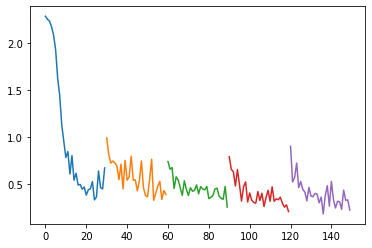

In [19]:
loss_plot(ewc_total_loss_100)

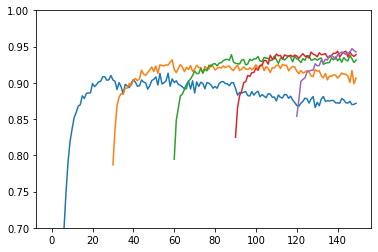

In [53]:
accuracy_plot(ewc_prec_100)

TypeError: 'NoneType' object is not subscriptable

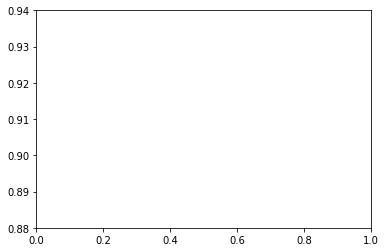

In [56]:
avg_precision_plot([ewc_prec_100])
    


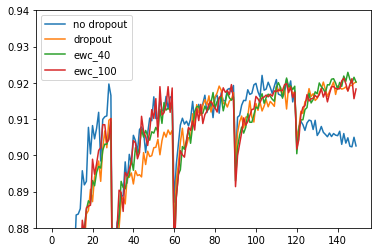

In [55]:
avg_precision_plot([standard_prec_no_dropout, standard_prec, ewc_prec, ewc_prec_100], ["no dropout", "dropout", "ewc_40", "ewc_100"])

In [ ]:
'''lamda = 1000
mlp_consolidation_1000 = MLP(
    DATASET_CONFIGS['mnist']['size']**2,
    DATASET_CONFIGS['mnist']['classes'],
    hidden_size,
    hidden_layer_num,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

# run the standard experiment.
consolidate = True
ewc_prec_1000, ewc_total_loss_1000, ewc_ce_loss_1000, ewc_ewc_loss_1000 =train(
    mlp_consolidation_1000, train_datasets, test_datasets,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)'''

In [ ]:
#loss_plot(ewc_total_loss_1000)

In [ ]:
#accuracy_plot(ewc_prec_1000)

In [ ]:
'''lamda = 10
mlp_consolidation_10 = MLP(
    DATASET_CONFIGS['mnist']['size']**2,
    DATASET_CONFIGS['mnist']['classes'],
    hidden_size,
    hidden_layer_num,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

# run the standard experiment.
consolidate = True
ewc_prec_10, ewc_total_loss_10, ewc_ce_loss_10, ewc_ewc_loss_10 =train(
    mlp_consolidation_10, train_datasets, test_datasets,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)'''

In [ ]:
#loss_plot(ewc_total_loss_10)

In [ ]:
#accuracy_plot(ewc_prec_10)

In [ ]:
'''lamda = 80
mlp_consolidation_80 = MLP(
    DATASET_CONFIGS['mnist']['size']**2,
    DATASET_CONFIGS['mnist']['classes'],
    hidden_size,
    hidden_layer_num,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

# run the standard experiment.
consolidate = True
ewc_prec_80, ewc_total_loss_80, ewc_ce_loss_80, ewc_ewc_loss_80 =train(
    mlp_consolidation_80, train_datasets, test_datasets,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)'''

In [ ]:
#loss_plot(ewc_total_loss_80)

In [ ]:
#accuracy_plot(ewc_prec_80)